In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense
import matplotlib.colors as colors
import os
import math
wells = []
##global scope variable for the path to where all the well data is stored
_PATH = "Data/"

Using TensorFlow backend.
/u/mgiordan/anaconda3/envs/energyanalytics/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/u/mgiordan/anaconda3/envs/energyanalytics/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/u/mgiordan/anaconda3/envs/energyanalytics/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# <span style="color:blue">This is a well class that will hold all the properties of a well and also will be able to perform relevant calculations for a given well</span>

In [2]:
class Well:
    ##This is a well class that will hold all the properties of a well
    ##and also will be able to do relevant calculations for a given well
    
    ##Once the data is set in the constructor, please do not change the values when they are accessed.
    ##Apparently I can't prevent this in Python, but I can at least advise against it.
    
    def __init__(self, easting, northing, porosity, permeability, PR, YM, wSaturation, oSaturation, thickness, proppant,
                 pumpRate, name, RF, Pa, FVF, oilByMonth, waterByMonth):
        self.easting = easting ##easting, areas with higher
        self.northing = northing ##northing, areas with higher
        self.porosity = porosity ##porosity, definitely something there
        self.permeability = permeability ##permeability,definitely something there
        self.PR = PR ##poissons's ratio, might be something. couple of outliers but general convergence
        self.YM = YM ##young's modulus, pyramid shape, probably something
        self.wSaturation = wSaturation ##water saturation, no correlation to production
        self.oSaturation = oSaturation ##oil saturation, no correlation to production
        self.thickness = thickness ##thickness, no correlation to production
        self.proppant = proppant ##proppant weight, maybe a correlation
        self.pumpRate = pumpRate ##pumpRate, probably a correlation
        self.name = name ##name
        self.RF = RF ##recovery factor, maybe something
        self.Pa = Pa ##average pressure, probably something
        self.FVF = FVF ##formation volume factor
        self.oilByMonth = oilByMonth ##oil produced in each month
        self.waterByMonth = waterByMonth ##water produced in each month
    
    ##returns the length of the well
    def getWellLength(self):
        return self.easting.max()-self.easting.min()
    
    #returns the total oil produced by the well
    def getTotalProduction(self):
        return self.oilByMonth.sum()
    
    ##returns the oil in place for this given well
    def getOilInPlace(self):
        return ((7758 * """ drainage area in acres""" 360 * self.thickness.mean() * self.porosity.mean() * (1 - self.wSaturation.mean())) / self.FVF)
        # 200k EUR -> 4-500k OOIP, total 4-6mil
        # individual well - 100k to 400k OOIP / well, aim for 200-250 mean
        # total EUR - up an order of magnitude
        
    ##returns the recoverable reserves of this well
    def getRecoverableReserves(self):
        return (self.getOilInPlace() * self.RF)
    
    ##Returns the production rate
    def InitialProduction(self):
        return (self.oilByMonth[0] * (math.exp((-1 * ((self.oilByMonth[11] - self.oilByMonth[0]) / 12) * time))))
        ##need to figure out how to plug in time (otherwise it will always equal first month production). also could be used
        ##to find the decline over time (where time is difference in production)
    
    ##Returns the economic limit of production
    def economicLimitROP(self):
        sumOilProduction = 0 
        for i in range(12):
            oil = self.oilByMonth[i]
            water = self.waterByMonth[i]
            sumOilProduction += oil
            if(oil < water):
                return sumOilProduction
    
    ##Returns time in years
    def LifeOfReservoir(self):
        return ((1 / ((self.oilByMonth[11] - self.oilByMonth[0]) / 12)) * math.log((self.oilByMonth[0]) / self.economicLimitROP()))
    
    ##Returns cumulative production in bbl
    def CumulativeProduction(self):
        return ((self.oilByMonth[0] / declineRate) * math.log(self.oilByMonth[0] / self.oilByMonth[11]))
    
    ##this is the kind of functioning as a toString right now, almost no reason for it
    def getName(self):
        return self.name
    
    ##method to return oil produced in a given month
    def getOilAtMonth(self, n):
        if n > 12 or n < 1:
            ##bad
            return -1
        else:
            return self.oilByMonth[n]
    
    ##method to return water produced in a given month
    def getOilAtMonth(self, n):
        if n > 12 or n < 1:
            ##bad
            return -1
        else:
            return self.waterByMonth[n]
    
    ##method to display data for this well
    ##depth will be for getiing data at a given depth in a well. Not sure if or when I should implement this
    def displayData(self, depth = 0):
        if depth == 0:
            data = pd.read_csv(_PATH + self.name + ".csv")
        else:
            data = pd.read_csv(_PATH + self.name + ".csv")
            
        print("Displaying data for: " + self.name)
        print(data)
    
    ##Returns the number of frac stages for a well
    def getFracStages(self):
        count = 0
        for rate in self.pumpRate:
            if (pd.notnull(rate)):
                count+=1
        return count
    
    ##Returns the mean pump rate of a well
    def getAvgPumpRate(self):
        return self.pumpRate.mean(skipna = True)
    
    ##Returns the mean amount of proppant used in a well
    def getAvgProppant(self):
        return self.proppant.mean(skipna = True)
    
    ##Returns the mean easting coordinate value of a well
    def eastingAvg(self):
        return np.array(self.easting).mean()
    
    ##Returns the mean northing coordinate value of a well
    def northingAvg(self):
        return np.array(self.northing).mean()
    
    ##Returns the mean porosity value of a well
    def porosityAvg(self):
        return np.array(self.porosity).mean()
    
    ##Returns the mean permeability value of a well
    def permeabilityAvg(self):
        return np.array(self.permeability).mean()

    ##method to take the data given, create a well object and store it in wells
def createWells():
    wellProduction = pd.read_csv(_PATH + "well production.csv")
    for i in range(100):
    ##for every well
        ##get all the data from the well production csv
        name = wellProduction.at[i, "well name"]
        ap = wellProduction.at[i, "average pressure (Pa)"]
        RF = wellProduction.at[i, "recovery factor"]
        FVF = wellProduction.at[i, "formation volume factor"]
        oil = wellProduction.iloc[i, 4:16] ##oil per month
        water = wellProduction.iloc[i, 16:28] ##water per month
        ##now that we have the name of the well, we can use that to access its
        ##own csv file and get that data
        wellDF = pd.read_csv(_PATH + name + ".csv")
        e = wellDF["easting"]
        n = wellDF["northing"]
        p = wellDF["porosity"]
        perm = wellDF["permeability"]
        pr = wellDF["Poisson's ratio"]
        ym = wellDF["Young's Modulus"]
        ws = wellDF["water saturation"]
        os = wellDF["oil saturation"]
        thick = wellDF["thickness (ft)"]
        prop = wellDF["proppant weight (lbs)"]
        pump = wellDF["pump rate (cubic feet/min)"]
        ##create a new well
        temp = Well(e, n, p, perm, pr, ym, ws, os, thick, prop, pump, name, RF, ap, FVF, oil, water)
        ##append the new well to the list
        wells.append(temp)


In [3]:
createWells()

# <span style="color:blue">This is a generalized function that facilitates easy graphing of any 2 variables</span> 

In [8]:
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((bottom(np.linspace(0, 1, 128))))[32:127]
newcmp = ListedColormap(newcolors, name='DarkerOrange')

def makeGraph(xProp, xIsMethod, yProp, yIsMethod, xLabel, yLabel, zProp=-1, zIsMethod=-1, zRepeat=1, zLabel=""):
    #Graph anything
    xCoords = []
    yCoords = []
    zCoords = []
    for well in wells:
        xAttr = getattr(well, xProp)
        yAttr = getattr(well, yProp)
        zAttr = getattr(well, zProp) if zProp is not -1 else -1
        xCoords.append(xAttr() if xIsMethod else xAttr)
        yCoords.append(yAttr() if yIsMethod else yAttr)
        zCoords.append(zAttr() if zIsMethod else zAttr) if zAttr is not -1 else -1
    xCoords = np.array(xCoords).reshape(-1)
    yCoords = np.array(yCoords).reshape(-1)
    zCoords = np.array(zCoords).repeat(zRepeat).reshape(-1)
    plt.figure(dpi=100)
    if zAttr is -1:
        plt.scatter(xCoords, yCoords, s = 4)
    else:
        plt.scatter(xCoords, yCoords, s = 4, c=zCoords, cmap=newcmp)
        plt.colorbar().set_label(zLabel)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

# <span style="color:blue">Total Production (bbl) vs Easting (ft)</span>

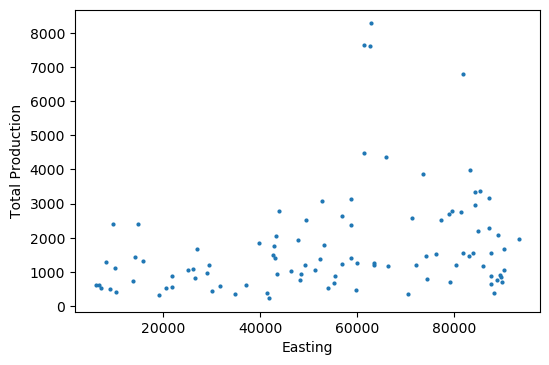

In [9]:
makeGraph("eastingAvg", True, "getTotalProduction", True, "Easting", "Total Production")

# <span style="color:blue">Total Production (bbl) vs Northing (ft)</span>

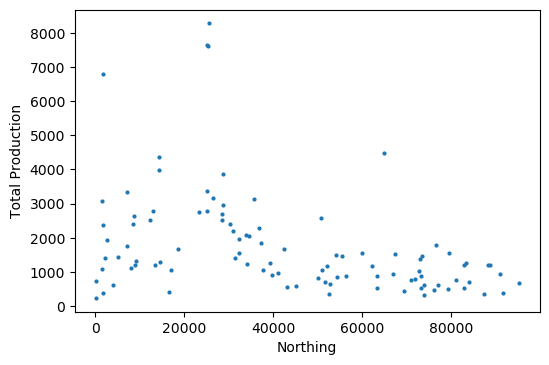

In [6]:
makeGraph("northingAvg", True, "getTotalProduction", True, "Northing", "Total Production")

# <span style="color:blue">Location of wells colored by Permeability 

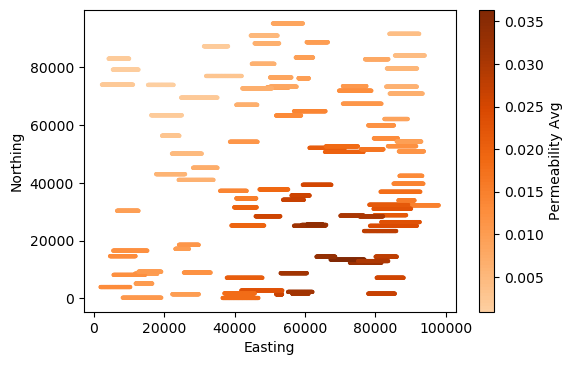

In [7]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="permeabilityAvg", zIsMethod=True, zRepeat=100, zLabel="Permeability Avg")

# <span style="color:blue">Location of wells colored by Total Production (bbl)</span>

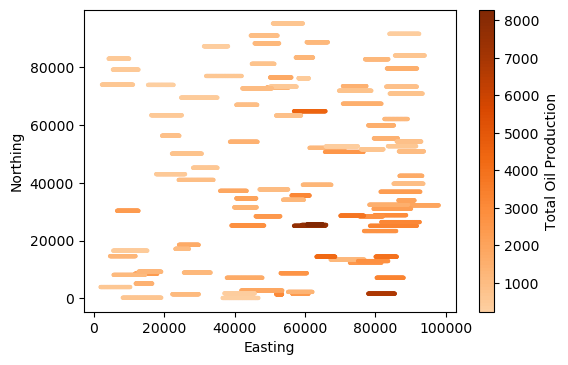

In [8]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="getTotalProduction", zIsMethod=True, zRepeat=100, zLabel="Total Oil Production")

# <span style="color:blue">Total Production (bbl) vs Well Length (ft)</span>

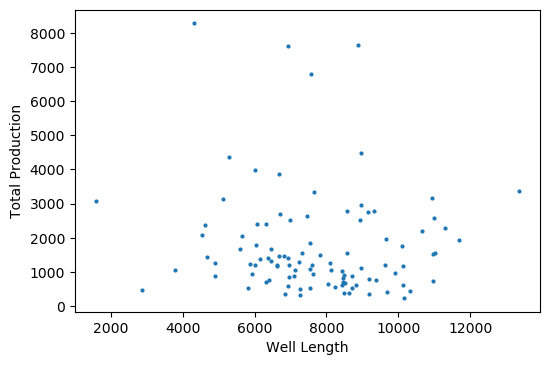

In [9]:
makeGraph("getWellLength", True, "getTotalProduction", True, "Well Length", "Total Production")

# <span style="color:blue">Frequency Plot of Well Lengths (ft)</span>

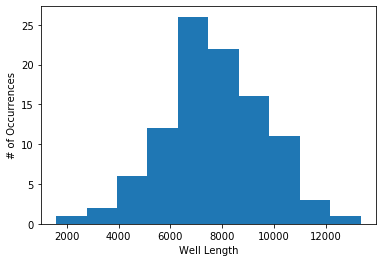

In [10]:
lengths = []
for well in wells:
    lengths.append(well.getWellLength())
plt.hist(lengths);
plt.xlabel("Well Length")
plt.ylabel("# of Occurrences");

# <span style="color:blue">Total Production (bbl) vs Mean Pump Rate (ft<sup>3</sup>/min)</span>

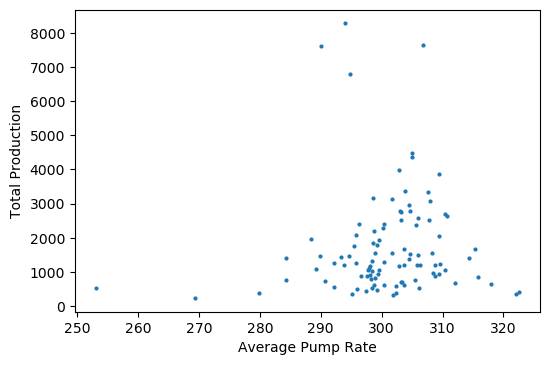

In [11]:
makeGraph("getAvgPumpRate", True, "getTotalProduction", True, "Average Pump Rate", "Total Production")

# <span style="color:blue">Total Production (bbl) vs Mean Proppant (lbs)</span>

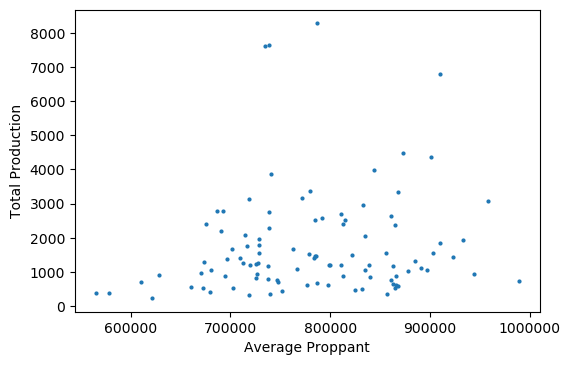

In [12]:
makeGraph("getAvgProppant", True, "getTotalProduction", True, "Average Proppant", "Total Production")

# <span style="color:blue">Total Production (bbl) vs Number of Frac Stages</span>

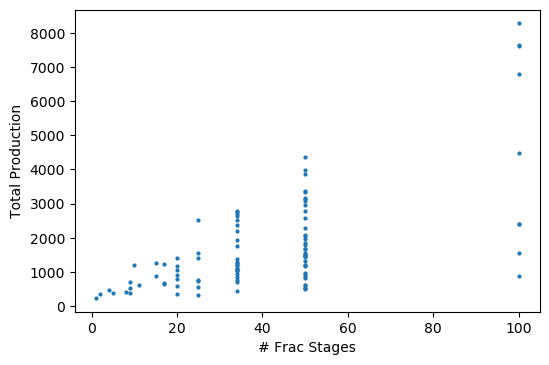

In [13]:
makeGraph("getFracStages", True, "getTotalProduction", True, "# Frac Stages", "Total Production")

# <span style="color:blue">Getting Top Outline Points</span>


In [14]:
def sparseMax2(xCoords1, yCoords1, sparseness):
    newX = []
    newY = []
    xRange = max(xCoords1)-min(xCoords1)
    width = xRange/sparseness
    lastUpper = 0
    for i in range(sparseness):
        lower = min(xCoords1) + width*i
        upper = min(xCoords1) + width*(i+1)

        maxN = -1
        maxInd = -1
        for j in range(len(xCoords1)):
            if (xCoords1[j] >= lower and xCoords1[j] < upper):
                if (yCoords1[j] > maxN):
                    maxN = yCoords1[j]
                    maxInd = j
                    
        if (maxInd != -1):
            newX.append(xCoords1[maxInd])
            newY.append(yCoords1[maxInd])
        lastUpper = upper
    
    newX.append(xCoords1[len(xCoords1)-1])
    newY.append(yCoords1[len(yCoords1)-1]) 
    
    return [newX, newY]
        

def removeOutliers(xCoords, yCoords):
    newX = []
    newY = []
    q1 = py.quantile(yCoords, 0.25)
    q3 = py.quantile(yCoords, 0.75)
    iqr = q3-q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    for i in range(len(yCoords)):
        if (yCoords[i] > lower and yCoords[i] < upper):
            newX.append(xCoords[i])
            newY.append(yCoords[i])
    return [newX, newY]

def getMaxLists(xCoords, yCoords):
    xCoords1 = []
    for val in xCoords:
        xCoords1.append(val)
    yCoords1 = [x for _,x in sorted(zip(xCoords,yCoords))]
    xCoords1.sort()
    #listA = removeOutliers(xCoords1, yCoords1)
    listA = [xCoords1, yCoords1]
    listZ = sparseMax2(listA[0], listA[1], 20)
    return listZ

Text(0, 0.5, 'Total Production')

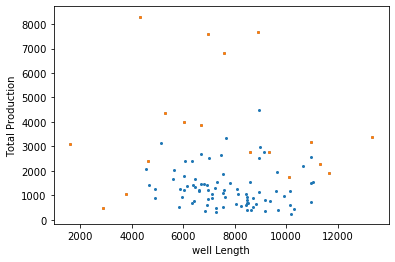

In [17]:
#Graph well length vs total production
xCoords = []
yCoords = []
for well in wells:
    xCoords.append(well.getWellLength())
    yCoords.append(well.getTotalProduction())

lengthMax = getMaxLists(xCoords, yCoords)

plt.scatter(xCoords, yCoords, s = 4)
plt.scatter(lengthMax[0], lengthMax[1], s = 4)
plt.xlabel("well Length")
plt.ylabel("Total Production")

# <span style="color:blue">Graph Frac stages vs Total Production</span>

Text(0, 0.5, 'Total Production')

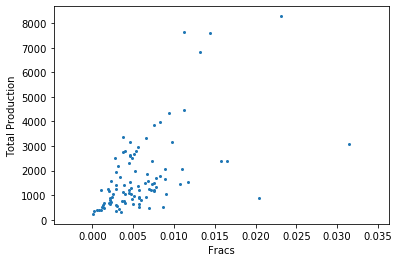

In [18]:
xCoords = []
yCoords = []
for well in wells:
    xCoords.append(well.getFracStages()/well.getWellLength())
    yCoords.append(well.getTotalProduction())

fracMax = getMaxLists(xCoords, yCoords)

plt.scatter(xCoords, yCoords, s = 4)
#plt.scatter(fracMax[0], fracMax[1], s = 4)
plt.xlabel("Fracs")
plt.ylabel("Total Production")

# <span style="color:blue">Graph Proppant vs Total Production</span>


Text(0, 0.5, 'Total Production')

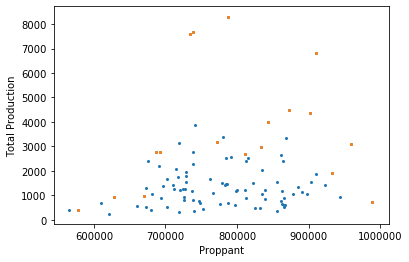

In [19]:
xCoords = []
yCoords = []
for well in wells:
    xCoords.append(well.getAvgProppant())
    yCoords.append(well.getTotalProduction())

propMax = getMaxLists(xCoords, yCoords)

plt.scatter(xCoords, yCoords, s = 4)
plt.scatter(propMax[0], propMax[1], s = 4)
plt.xlabel("Proppant")
plt.ylabel("Total Production")

# <span style="color:blue">Graph Pump Rate vs Total Production</span>

Text(0, 0.5, 'Total Production')

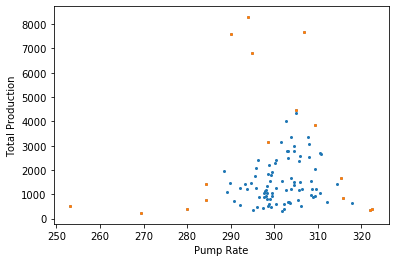

In [20]:
xCoords = []
yCoords = []
for well in wells:
    xCoords.append(well.getAvgPumpRate())
    yCoords.append(well.getTotalProduction())

pumpMax = getMaxLists(xCoords, yCoords)

plt.scatter(xCoords, yCoords, s = 4)
plt.scatter(pumpMax[0], pumpMax[1], s = 4)
plt.xlabel("Pump Rate")
plt.ylabel("Total Production")

# <span style="color:blue">Function to show Data vs Fit for Production vs Well Length</span>

[5177.42871451 7351.87636661 2817.66717551]
Since we used the Gaussian curve as our fit, the x value at the max y value is simply the optimized x0 value : 7352


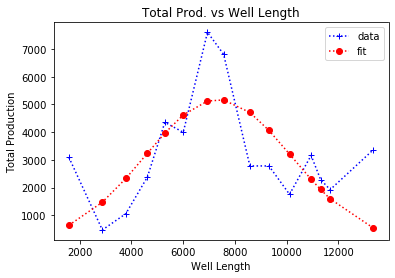

In [21]:
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
x1 = []
for val in lengthMax[0]:
    x1.append(val)
y1 = []
for val in lengthMax[1]:
    y1.append(val)
    
# only this one necessarily had to have outliers removed so that the optimizer would converge
del x1[11]
del x1[7]
del x1[3]
del y1[11]
del y1[7]
del y1[3]

x = ar(x1)
y = ar(y1)

n = len(x)                          
mean = sum(x*y)/n                   
sigma = np.sqrt(sum(y*(x-mean)**2)/sum(y))

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma])
print(popt)
print("Since we used the Gaussian curve as our fit, the x value at the max y value is simply the optimized x0 value : 7352")
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x, popt[0], popt[1], popt[2]),'ro:',label='fit')
plt.legend()
plt.title('Total Prod. vs Well Length')
plt.xlabel('Well Length')
plt.ylabel('Total Production')
plt.show()

# <span style="color:blue">Function to show Data vs Fit for Production vs Pump Proppant</span>

[  5436.10099638 804423.96855074 116222.29747927]
Since we used the Gaussian curve as our fit, the x value at the max y value is simply the optimized x0 value : 804422


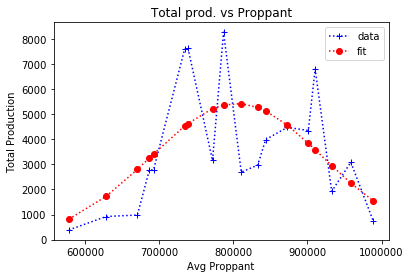

In [22]:
x1 = []
for val in propMax[0]:
    x1.append(val)
y1 = []
for val in propMax[1]:
    y1.append(val)

x = ar(x1)
y = ar(y1)

n = len(x)                          
mean = sum(x*y)/n                  
sigma = np.sqrt(sum(y*(x-mean)**2)/sum(y))        

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma])
print(popt)
print("Since we used the Gaussian curve as our fit, the x value at the max y value is simply the optimized x0 value : 804422")
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x, popt[0], popt[1], popt[2]),'ro:',label='fit')
plt.legend()
plt.title('Total prod. vs Proppant')
plt.xlabel('Avg Proppant')
plt.ylabel('Total Production')
plt.show()

# <span style="color:blue">Function to show Data vs Fit for Production vs Pump Rate</span>

[6983.16327467  298.45646071    9.83216425]
Since we used the Gaussian curve as our fit, the x value at the max y value is simply the optimized x0 value : 298


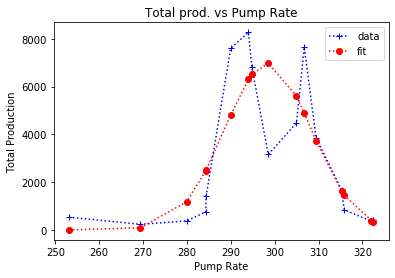

In [23]:
x1 = []
for val in pumpMax[0]:
    x1.append(val)
y1 = []
for val in pumpMax[1]:
    y1.append(val)

x = ar(x1)
y = ar(y1)

n = len(x)      
mean = sum(x*y)/n                 
sigma = np.sqrt(sum(y*(x-mean)**2)/sum(y)) 

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma])
print(popt)
print("Since we used the Gaussian curve as our fit, the x value at the max y value is simply the optimized x0 value : 298")
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x, popt[0], popt[1], popt[2]),'ro:',label='fit')
plt.legend()
plt.title('Total prod. vs Pump Rate')
plt.xlabel('Pump Rate')
plt.ylabel('Total Production')
plt.show()

# <span style="color:blue">Location of wells colored by Pump Rate (ft<sup>3</sup>/min)</span>

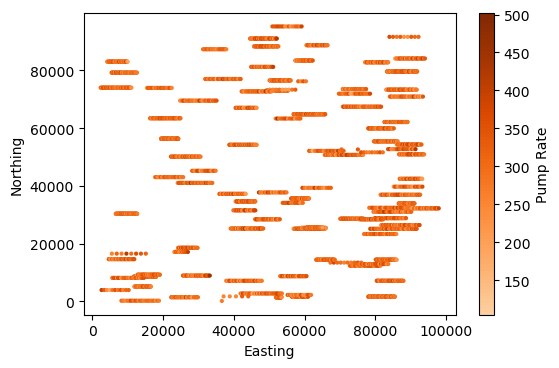

In [24]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="pumpRate", zIsMethod=False, zLabel="Pump Rate")

# <span style="color:blue">Total Production (bbl) vs Mean Porosity</span>

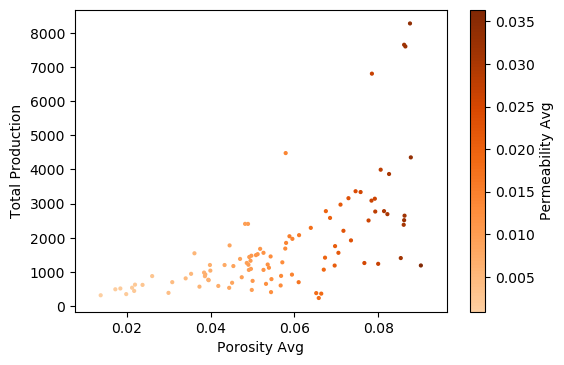

In [25]:
makeGraph("porosityAvg", True, "getTotalProduction", True, "Porosity Avg", "Total Production", zProp="permeabilityAvg", zIsMethod=True, zLabel="Permeability Avg")

# <span style="color:blue">Location of wells colored by Porosity</span>

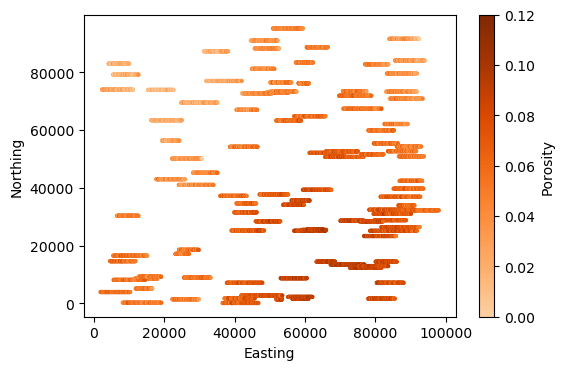

In [26]:
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="porosity", zIsMethod=False, zLabel="Porosity")

# <span style="color:blue">Making the 10 optimal wells</span>

In [17]:
def genCoords(x, y):
    return np.linspace([x, y], [x+7352, y], 100)
addedWells = [
    genCoords(88430, 1000),
    genCoords(66000, 6000),
    genCoords(85500, 19500),
    genCoords(51500, 20000), # top good one
    genCoords(53750, 21500), # middle good one
    genCoords(55000, 23000), # bottom good one
    genCoords(62000, 30500),
    genCoords(27025, 72000),
    genCoords(53000, 59250),
    genCoords(61750, 67250)
]
addedWellClasses = [Well(adde[:,0], adde[:,1], None, None, None, None, None, None, None, None,
                 None, None, None, None, 1.6, None, None) for adde in addedWells]

<Figure size 600x400 with 0 Axes>

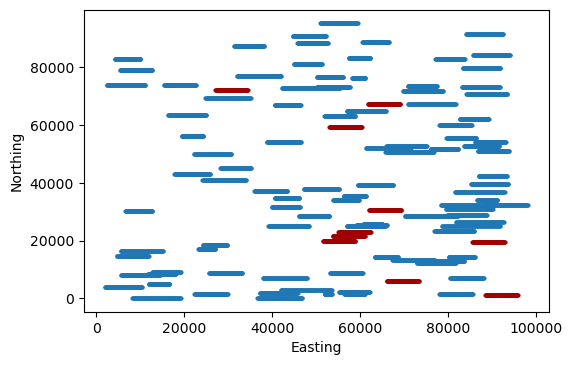

In [18]:
plt.figure(dpi=100)
makeGraph("easting", False, "northing", False, "Easting", "Northing")
plt.scatter(np.array([(addedWell)[:,0] for addedWell in addedWells]).reshape(-1), np.array([(addedWell)[:,1] for addedWell in addedWells]).reshape(-1), c="#A00000", s=4)


<Figure size 600x400 with 0 Axes>

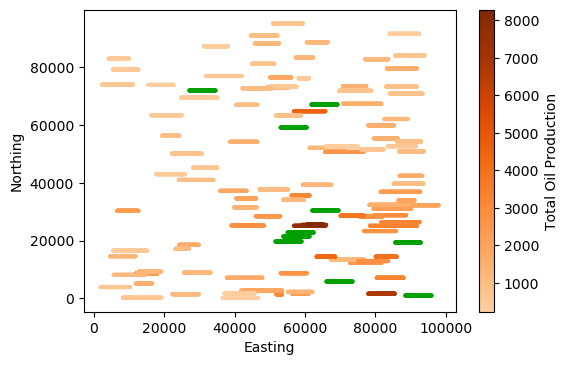

In [19]:
plt.figure(dpi=100)
makeGraph("easting", False, "northing", False, "Easting", "Northing", zProp="getTotalProduction", zIsMethod=True, zRepeat=100, zLabel="Total Oil Production")
plt.scatter(np.array([(addedWell)[:,0] for addedWell in addedWells]).reshape(-1), np.array([(addedWell)[:,1] for addedWell in addedWells]).reshape(-1), c="#00A000", s=4)

# <span style="color:blue">Making the Neural Network</span>

In [20]:
class NNetwork:
    def parseData(self, targetProperty, isTargetMethod, yLabel, yRepeat=1):
        self.yLabel = yLabel
        self.X = np.array([np.array([well.easting, well.northing]).transpose() for well in wells]).reshape(-1,2)
        self.y = np.array([np.array(getattr(well, targetProperty)).repeat(yRepeat) for well in wells]).reshape(-1)
        
        self.X = self.X[::25]
        self.y = self.y[::25]

        if isTargetMethod:
            self.y = np.array([a() for a in self.y])

        self.scalarX = MinMaxScaler()
        self.scalarX.fit(self.X)
        self.Xfit = self.scalarX.transform(self.X)
        self.scalarY = MinMaxScaler()
        self.scalarY.fit(self.y.reshape(-1,1))
        self.yfit = self.scalarY.transform(self.y.reshape(-1,1)).reshape(-1)

    def train(self):
        # Definition of our model
        self.model = keras.Sequential() # as first layer in a sequential model:
        # let's define our model:
        self.model.add( keras.layers.Dense( units=30, input_shape=(2,), activation="relu" ) )
        self.model.add( keras.layers.Dense( units=15, input_shape=(30,), activation="relu" ) )
        self.model.add( keras.layers.Dense( units=15, input_shape=(15,), activation="relu" ) )
        self.model.add( keras.layers.Dense( units=1, input_shape=(15,), activation="linear" ) )
        optimizer = keras.optimizers.Adam()
        self.model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
        self.model.fit(self.Xfit, self.yfit, epochs=3000, verbose=1, batch_size=200, validation_split = 0.1)

        
    def plotSimple(self):
        testX0 = np.linspace(min(self.Xfit[:,0]), max(self.Xfit[:,0]), 50)
        testX1 = np.linspace(min(self.Xfit[:,1]), max(self.Xfit[:,1]), 50)
        grid0, grid1 = np.meshgrid(testX0, testX1)
        cost = np.array([self.model.predict(np.array([grid0[i], grid1[i]]).transpose()).reshape(-1) for i in range(len(grid0))])
        plt.figure(dpi=100)
        plt.pcolormesh(grid0,grid1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                  vmin=cost.min(), vmax=cost.max()))
        plt.scatter(self.Xfit[:,0], self.Xfit[:,1], c = self.yfit)
        plt.scatter(np.array([self.scalarX.transform(addedWell)[:,0] for addedWell in addedWells]).reshape(-1), np.array([self.scalarX.transform(addedWell)[:,1] for addedWell in addedWells]).reshape(-1), c="#A00000", s=4)
        plt.colorbar().set_label(self.yLabel)
        plt.xlabel("Easting")
        plt.ylabel("Northing")
        plt.show()
        
    # Doesn't work properly yet - don't use ATM
    def plotAdvanced(self):
        testX0 = np.linspace(min(self.Xfit[:,0]), max(self.Xfit[:,0]), 50)
        testX1 = np.linspace(min(self.Xfit[:,1]), max(self.Xfit[:,1]), 50)
        grid0, grid1 = np.meshgrid(testX0, testX1)
        cost = np.array([self.model.predict(np.array([grid0[i], grid1[i]]).transpose()).reshape(-1) for i in range(len(grid0))])
        
        cost = self.scalarY.inverse_transform(cost)
        
        reset = self.scalarX.inverse_transform(np.array([testX0, testX1]).transpose())
        testX00 = reset[:,0]
        testX01 = reset[:,1]
        grid0, grid1 = np.meshgrid(testX00, testX01)
        
        plt.pcolormesh(grid0,grid1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                  vmin=cost.min(), vmax=cost.max()))
        plt.scatter(self.X[:,0], self.X[:,1], c = self.y)
        plt.colorbar().set_label(self.yLabel)
        plt.xlabel("Easting")
        plt.ylabel("Northing")
        plt.show()
        
    def getNetwork(self):
        return (self.model, self.scalarX, self.scalarY)

In [21]:
porosityNet = NNetwork()
thicknessNet = NNetwork()
wSaturationNet = NNetwork()
RFNet = NNetwork()
totalOilNet = NNetwork()

porosityNet.parseData("porosity", False, "Porosity")
thicknessNet.parseData("thickness", False, "Thickness")
wSaturationNet.parseData("wSaturation", False, "Water Saturation")
RFNet.parseData("RF", False, "Recovery Factor", yRepeat=100)
totalOilNet.parseData("getTotalProduction", True, "Total Oil Production", yRepeat=100)

# <span style="color:blue">Training the Neural Network</span>

In [22]:
#our error metric is the loss metric (mean-squared error)
porosityNet.train()
thicknessNet.train()
wSaturationNet.train()
RFNet.train()
totalOilNet.train()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 360 samples, validate on 40 samples
Epoch 1/3000
360/360 [==============================] - 0s 389us/step - loss: 0.2289 - mean_squared_error: 0.2289 - val_loss: 0.3296 - val_mean_squared_error: 0.3296
Epoch 2/3000
360/360 [==============================] - 0s 19us/step - loss: 0.2096 - mean_squared_error: 0.2096 - val_loss: 0.3071 - val_mean_squared_error: 0.3071
Epoch 3/3000
360/360 [==============================] - 0s 23us/step - loss: 0.1896 - mean_squared_error: 0.1896 - val_loss: 0.2826 - val_mean_squared_error: 0.2826
Epoch 4/3000
360/360 [==============================] - 0s 21us/step - loss: 0.1700 - mean_squared_error: 0.1700 - val_loss: 0.2577 - val_mean_squared_error: 0.2577
Epoch 5/3000
360/360 [==============================] - 0s 15us/step - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.2329 - val_mean_squared_error: 0.2329
Epoch 6/3

360/360 [==============================] - 0s 15us/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 47/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 48/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 49/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 50/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 51/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 52/3000
360/

360/360 [==============================] - 0s 21us/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 96/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 97/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 98/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 99/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 100/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 101/3000
36

360/360 [==============================] - 0s 18us/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 145/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 146/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 147/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 148/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 149/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 150/300

360/360 [==============================] - 0s 22us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 194/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 195/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 196/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 197/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 198/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 199/300

360/360 [==============================] - 0s 18us/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 243/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 244/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 245/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 246/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 247/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 248/300

360/360 [==============================] - 0s 18us/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 292/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 293/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 294/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 295/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 296/3000
360/360 [==============================] - 0s 13us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 297/300

360/360 [==============================] - 0s 15us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 341/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 342/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 343/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 344/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 345/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 346/300

360/360 [==============================] - 0s 14us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 390/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 391/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 392/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 393/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 394/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 395/300

360/360 [==============================] - 0s 20us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 439/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 440/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 441/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 442/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 443/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 444/300

360/360 [==============================] - 0s 23us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 488/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 489/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 490/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 491/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 492/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 493/300

360/360 [==============================] - 0s 15us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 537/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 538/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 539/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 540/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 541/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 542/300

360/360 [==============================] - 0s 16us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 586/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 587/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 588/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 589/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 590/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 591/300

360/360 [==============================] - 0s 20us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 635/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 636/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 637/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 638/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 639/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 640/300

360/360 [==============================] - 0s 15us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 684/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 685/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 686/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 687/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 688/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 689/300

360/360 [==============================] - 0s 15us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 733/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 734/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 735/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 736/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 737/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 738/300

360/360 [==============================] - 0s 21us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 782/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 783/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 784/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 785/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 786/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 787/300

360/360 [==============================] - 0s 21us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 831/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 832/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 833/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 834/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 835/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 836/300

360/360 [==============================] - 0s 16us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 880/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 881/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 882/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 883/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 884/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 885/300

360/360 [==============================] - 0s 17us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 929/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 930/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 931/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 932/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 933/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 934/300

360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 978/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 979/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 980/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 981/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 982/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 983/300

Epoch 1026/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1027/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 1028/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 1029/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1030/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1031/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0128 - val_mean_squared_error:

Epoch 1075/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1076/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1077/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1078/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 1079/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1080/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0133 - val_mean_squared_error:

Epoch 1124/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1125/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1126/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 1127/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1128/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1129/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error:

Epoch 1173/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1174/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1175/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1176/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 1177/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1178/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0132 - val_mean_squared_error:

Epoch 1222/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1223/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1224/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1225/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1226/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1227/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error:

Epoch 1271/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 1272/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1273/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 1274/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1275/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 1276/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0129 - val_mean_squared_error:

Epoch 1320/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1321/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 1322/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1323/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1324/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1325/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0129 - val_mean_squared_error:

Epoch 1369/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1370/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 1371/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 1372/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1373/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 1374/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error:

Epoch 1418/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1419/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1420/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1421/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 1422/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1423/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error:

Epoch 1467/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1468/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1469/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1470/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1471/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1472/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0130 - val_mean_squared_error:

Epoch 1516/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1517/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1518/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1519/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1520/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1521/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error:

Epoch 1565/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1566/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1567/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1568/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1569/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1570/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0127 - val_mean_squared_error:

Epoch 1614/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1615/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1616/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1617/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1618/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1619/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0135 - val_mean_squared_error:

Epoch 1663/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 1664/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1665/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1666/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1667/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1668/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error:

Epoch 1712/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 1713/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1714/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1715/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1716/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 1717/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error:

Epoch 1761/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1762/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1763/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 1764/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 1765/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1766/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0127 - val_mean_squared_error:

Epoch 1810/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1811/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1812/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 1813/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 1814/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1815/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0128 - val_mean_squared_error:

Epoch 1859/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1860/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1861/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1862/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 1863/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1864/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0132 - val_mean_squared_error:

Epoch 1908/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 1909/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1910/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1911/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1912/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1913/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0135 - val_mean_squared_error:

Epoch 1957/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1958/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 1959/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 1960/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1961/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 1962/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0139 - val_mean_squared_error:

Epoch 2006/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2007/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2008/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 2009/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2010/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2011/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0143 - val_mean_squared_error:

Epoch 2055/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 2056/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2057/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 2058/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2059/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2060/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0142 - val_mean_squared_error:

Epoch 2104/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 2105/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2106/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2107/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2108/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2109/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0143 - val_mean_squared_error:

Epoch 2153/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 2154/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2155/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2156/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 2157/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 2158/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0134 - val_mean_squared_error:

Epoch 2202/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2203/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 2204/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 2205/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 2206/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2207/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0137 - val_mean_squared_error:

Epoch 2251/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2252/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 2253/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 2254/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2255/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2256/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0137 - val_mean_squared_error:

Epoch 2300/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 2301/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2302/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2303/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2304/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2305/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0143 - val_mean_squared_error:

Epoch 2349/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2350/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2351/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2352/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2353/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2354/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0143 - val_mean_squared_error:

Epoch 2398/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2399/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2400/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2401/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2402/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2403/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0134 - val_mean_squared_error:

Epoch 2447/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2448/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 2449/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2450/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2451/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 2452/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0136 - val_mean_squared_error:

Epoch 2496/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 2497/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2498/3000
360/360 [==============================] - 0s 13us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2499/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 2500/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2501/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0136 - val_mean_squared_error:

Epoch 2545/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2546/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2547/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 2548/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2549/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2550/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0140 - val_mean_squared_error:

Epoch 2594/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 2595/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2596/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2597/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2598/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 2599/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0143 - val_mean_squared_error:

Epoch 2643/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2644/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2645/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2646/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2647/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2648/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0137 - val_mean_squared_error:

Epoch 2692/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2693/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2694/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 2695/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2696/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2697/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0142 - val_mean_squared_error:

Epoch 2741/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2742/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 2743/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 2744/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 2745/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2746/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0138 - val_mean_squared_error:

Epoch 2790/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2791/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2792/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2793/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2794/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 2795/3000
360/360 [==============================] - 0s 13us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0145 - val_mean_squared_error:

Epoch 2839/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2840/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2841/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2842/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2843/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2844/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0157 - val_mean_squared_error:

Epoch 2888/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 2889/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 2890/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2891/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 2892/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2893/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0136 - val_mean_squared_error:

Epoch 2937/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 2938/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 2939/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2940/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2941/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 2942/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0142 - val_mean_squared_error:

Epoch 2986/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2987/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 2988/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 2989/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2990/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 2991/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0142 - val_mean_squared_error:

Epoch 35/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0667 - mean_squared_error: 0.0667 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 36/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0622 - val_mean_squared_error: 0.0622
Epoch 37/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0626 - val_mean_squared_error: 0.0626
Epoch 38/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0631 - val_mean_squared_error: 0.0631
Epoch 39/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 40/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoc

360/360 [==============================] - 0s 16us/step - loss: 0.0552 - mean_squared_error: 0.0552 - val_loss: 0.0553 - val_mean_squared_error: 0.0553
Epoch 85/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 86/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 87/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0543 - mean_squared_error: 0.0543 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 88/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0546 - val_mean_squared_error: 0.0546
Epoch 89/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0541 - val_mean_squared_error: 0.0541
Epoch 90/3000
360/

360/360 [==============================] - 0s 22us/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 134/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 135/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 136/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 137/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 138/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 139/300

360/360 [==============================] - 0s 16us/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 183/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 184/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 185/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 186/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 187/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 188/300

360/360 [==============================] - 0s 22us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 232/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 233/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 234/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 235/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 236/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 237/300

360/360 [==============================] - 0s 16us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 281/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 282/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 283/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 284/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 285/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 286/300

Epoch 329/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 330/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 331/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 332/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 333/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 334/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0085 - val_mean_squared_error: 0.008

360/360 [==============================] - 0s 20us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 379/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 380/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 381/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 382/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 383/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 384/300

360/360 [==============================] - 0s 17us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 428/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 429/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 430/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 431/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 432/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 433/300

360/360 [==============================] - 0s 16us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 477/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 478/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 479/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 480/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 481/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 482/300

360/360 [==============================] - 0s 15us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 526/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 527/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 528/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 529/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 530/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 531/300

360/360 [==============================] - 0s 18us/step - loss: 9.3103e-04 - mean_squared_error: 9.3103e-04 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 574/3000
360/360 [==============================] - 0s 16us/step - loss: 9.4363e-04 - mean_squared_error: 9.4363e-04 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 575/3000
360/360 [==============================] - 0s 15us/step - loss: 9.5989e-04 - mean_squared_error: 9.5989e-04 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 576/3000
360/360 [==============================] - 0s 16us/step - loss: 9.3293e-04 - mean_squared_error: 9.3293e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 577/3000
360/360 [==============================] - 0s 23us/step - loss: 9.6152e-04 - mean_squared_error: 9.6152e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 578/3000
360/360 [==============================] - 0s 16us/step - loss: 9.4558e-04 - mean_squared_error: 9.4558e-04 - val_loss: 0.007

Epoch 620/3000
360/360 [==============================] - 0s 23us/step - loss: 8.5411e-04 - mean_squared_error: 8.5411e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 621/3000
360/360 [==============================] - 0s 16us/step - loss: 8.4087e-04 - mean_squared_error: 8.4087e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 622/3000
360/360 [==============================] - 0s 15us/step - loss: 8.3278e-04 - mean_squared_error: 8.3278e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 623/3000
360/360 [==============================] - 0s 16us/step - loss: 8.6576e-04 - mean_squared_error: 8.6576e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 624/3000
360/360 [==============================] - 0s 25us/step - loss: 8.6531e-04 - mean_squared_error: 8.6531e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 625/3000
360/360 [==============================] - 0s 20us/step - loss: 8.4944e-04 - mean_squared_error: 8.4944e-04 - 

Epoch 667/3000
360/360 [==============================] - 0s 16us/step - loss: 7.5661e-04 - mean_squared_error: 7.5661e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 668/3000
360/360 [==============================] - 0s 17us/step - loss: 7.6513e-04 - mean_squared_error: 7.6513e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 669/3000
360/360 [==============================] - 0s 17us/step - loss: 7.5843e-04 - mean_squared_error: 7.5843e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 670/3000
360/360 [==============================] - 0s 20us/step - loss: 7.5063e-04 - mean_squared_error: 7.5063e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 671/3000
360/360 [==============================] - 0s 20us/step - loss: 7.5007e-04 - mean_squared_error: 7.5007e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 672/3000
360/360 [==============================] - 0s 20us/step - loss: 7.7646e-04 - mean_squared_error: 7.7646e-04 - 

Epoch 714/3000
360/360 [==============================] - 0s 16us/step - loss: 6.7507e-04 - mean_squared_error: 6.7507e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 715/3000
360/360 [==============================] - 0s 22us/step - loss: 6.7996e-04 - mean_squared_error: 6.7996e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 716/3000
360/360 [==============================] - 0s 19us/step - loss: 6.6680e-04 - mean_squared_error: 6.6680e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 717/3000
360/360 [==============================] - 0s 19us/step - loss: 6.7742e-04 - mean_squared_error: 6.7742e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 718/3000
360/360 [==============================] - 0s 14us/step - loss: 6.6608e-04 - mean_squared_error: 6.6608e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 719/3000
360/360 [==============================] - 0s 16us/step - loss: 6.7335e-04 - mean_squared_error: 6.7335e-04 - 

Epoch 761/3000
360/360 [==============================] - 0s 18us/step - loss: 6.4318e-04 - mean_squared_error: 6.4318e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 762/3000
360/360 [==============================] - 0s 18us/step - loss: 6.3101e-04 - mean_squared_error: 6.3101e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 763/3000
360/360 [==============================] - 0s 20us/step - loss: 6.3887e-04 - mean_squared_error: 6.3887e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 764/3000
360/360 [==============================] - 0s 16us/step - loss: 6.2894e-04 - mean_squared_error: 6.2894e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 765/3000
360/360 [==============================] - 0s 16us/step - loss: 6.1954e-04 - mean_squared_error: 6.1954e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 766/3000
360/360 [==============================] - 0s 19us/step - loss: 6.3557e-04 - mean_squared_error: 6.3557e-04 - 

Epoch 808/3000
360/360 [==============================] - 0s 22us/step - loss: 5.8028e-04 - mean_squared_error: 5.8028e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 809/3000
360/360 [==============================] - 0s 18us/step - loss: 5.7837e-04 - mean_squared_error: 5.7837e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 810/3000
360/360 [==============================] - 0s 16us/step - loss: 5.8061e-04 - mean_squared_error: 5.8061e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 811/3000
360/360 [==============================] - 0s 18us/step - loss: 5.7904e-04 - mean_squared_error: 5.7904e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 812/3000
360/360 [==============================] - 0s 21us/step - loss: 5.8838e-04 - mean_squared_error: 5.8838e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 813/3000
360/360 [==============================] - 0s 24us/step - loss: 5.7914e-04 - mean_squared_error: 5.7914e-04 - 

Epoch 855/3000
360/360 [==============================] - 0s 22us/step - loss: 5.5003e-04 - mean_squared_error: 5.5003e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 856/3000
360/360 [==============================] - 0s 18us/step - loss: 5.3951e-04 - mean_squared_error: 5.3951e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 857/3000
360/360 [==============================] - 0s 15us/step - loss: 5.6165e-04 - mean_squared_error: 5.6165e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 858/3000
360/360 [==============================] - 0s 15us/step - loss: 5.5024e-04 - mean_squared_error: 5.5024e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 859/3000
360/360 [==============================] - 0s 17us/step - loss: 5.4181e-04 - mean_squared_error: 5.4181e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 860/3000
360/360 [==============================] - 0s 18us/step - loss: 5.4066e-04 - mean_squared_error: 5.4066e-04 - 

Epoch 902/3000
360/360 [==============================] - 0s 23us/step - loss: 5.1947e-04 - mean_squared_error: 5.1947e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 903/3000
360/360 [==============================] - 0s 22us/step - loss: 5.3047e-04 - mean_squared_error: 5.3047e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 904/3000
360/360 [==============================] - 0s 18us/step - loss: 5.2148e-04 - mean_squared_error: 5.2148e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 905/3000
360/360 [==============================] - 0s 20us/step - loss: 5.2109e-04 - mean_squared_error: 5.2109e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 906/3000
360/360 [==============================] - 0s 20us/step - loss: 5.1697e-04 - mean_squared_error: 5.1697e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 907/3000
360/360 [==============================] - 0s 19us/step - loss: 5.2247e-04 - mean_squared_error: 5.2247e-04 - 

Epoch 949/3000
360/360 [==============================] - 0s 19us/step - loss: 4.9644e-04 - mean_squared_error: 4.9644e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 950/3000
360/360 [==============================] - 0s 21us/step - loss: 5.1450e-04 - mean_squared_error: 5.1450e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 951/3000
360/360 [==============================] - 0s 24us/step - loss: 5.4970e-04 - mean_squared_error: 5.4970e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 952/3000
360/360 [==============================] - 0s 20us/step - loss: 5.0916e-04 - mean_squared_error: 5.0916e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 953/3000
360/360 [==============================] - 0s 22us/step - loss: 5.0575e-04 - mean_squared_error: 5.0575e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 954/3000
360/360 [==============================] - 0s 22us/step - loss: 5.3146e-04 - mean_squared_error: 5.3146e-04 - 

Epoch 996/3000
360/360 [==============================] - 0s 16us/step - loss: 5.0852e-04 - mean_squared_error: 5.0852e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 997/3000
360/360 [==============================] - 0s 15us/step - loss: 5.3782e-04 - mean_squared_error: 5.3782e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 998/3000
360/360 [==============================] - 0s 16us/step - loss: 5.3576e-04 - mean_squared_error: 5.3576e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 999/3000
360/360 [==============================] - 0s 17us/step - loss: 5.1653e-04 - mean_squared_error: 5.1653e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 1000/3000
360/360 [==============================] - 0s 22us/step - loss: 5.0301e-04 - mean_squared_error: 5.0301e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1001/3000
360/360 [==============================] - 0s 23us/step - loss: 5.1778e-04 - mean_squared_error: 5.1778e-04 

360/360 [==============================] - 0s 22us/step - loss: 4.9674e-04 - mean_squared_error: 4.9674e-04 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 1043/3000
360/360 [==============================] - 0s 16us/step - loss: 4.7964e-04 - mean_squared_error: 4.7964e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 1044/3000
360/360 [==============================] - 0s 20us/step - loss: 5.0003e-04 - mean_squared_error: 5.0003e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1045/3000
360/360 [==============================] - 0s 17us/step - loss: 5.0161e-04 - mean_squared_error: 5.0161e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1046/3000
360/360 [==============================] - 0s 16us/step - loss: 5.3483e-04 - mean_squared_error: 5.3483e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1047/3000
360/360 [==============================] - 0s 20us/step - loss: 4.9748e-04 - mean_squared_error: 4.9748e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 4.7406e-04 - mean_squared_error: 4.7406e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1089/3000
360/360 [==============================] - 0s 20us/step - loss: 4.6220e-04 - mean_squared_error: 4.6220e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1090/3000
360/360 [==============================] - 0s 22us/step - loss: 4.5650e-04 - mean_squared_error: 4.5650e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1091/3000
360/360 [==============================] - 0s 23us/step - loss: 4.5709e-04 - mean_squared_error: 4.5709e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1092/3000
360/360 [==============================] - 0s 22us/step - loss: 4.6039e-04 - mean_squared_error: 4.6039e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1093/3000
360/360 [==============================] - 0s 21us/step - loss: 4.5112e-04 - mean_squared_error: 4.5112e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 4.7833e-04 - mean_squared_error: 4.7833e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1135/3000
360/360 [==============================] - 0s 17us/step - loss: 4.9601e-04 - mean_squared_error: 4.9601e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1136/3000
360/360 [==============================] - 0s 17us/step - loss: 4.6011e-04 - mean_squared_error: 4.6011e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 1137/3000
360/360 [==============================] - 0s 15us/step - loss: 4.9243e-04 - mean_squared_error: 4.9243e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1138/3000
360/360 [==============================] - 0s 23us/step - loss: 4.5247e-04 - mean_squared_error: 4.5247e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 1139/3000
360/360 [==============================] - 0s 21us/step - loss: 5.1639e-04 - mean_squared_error: 5.1639e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 4.3624e-04 - mean_squared_error: 4.3624e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1181/3000
360/360 [==============================] - 0s 21us/step - loss: 4.4228e-04 - mean_squared_error: 4.4228e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1182/3000
360/360 [==============================] - 0s 16us/step - loss: 4.5336e-04 - mean_squared_error: 4.5336e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1183/3000
360/360 [==============================] - 0s 14us/step - loss: 4.5691e-04 - mean_squared_error: 4.5691e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1184/3000
360/360 [==============================] - 0s 15us/step - loss: 4.3844e-04 - mean_squared_error: 4.3844e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1185/3000
360/360 [==============================] - 0s 22us/step - loss: 4.6135e-04 - mean_squared_error: 4.6135e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 4.3953e-04 - mean_squared_error: 4.3953e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1227/3000
360/360 [==============================] - 0s 16us/step - loss: 4.4235e-04 - mean_squared_error: 4.4235e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1228/3000
360/360 [==============================] - 0s 17us/step - loss: 4.5827e-04 - mean_squared_error: 4.5827e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1229/3000
360/360 [==============================] - 0s 16us/step - loss: 4.5033e-04 - mean_squared_error: 4.5033e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1230/3000
360/360 [==============================] - 0s 17us/step - loss: 4.2736e-04 - mean_squared_error: 4.2736e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1231/3000
360/360 [==============================] - 0s 16us/step - loss: 4.5579e-04 - mean_squared_error: 4.5579e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 4.2416e-04 - mean_squared_error: 4.2416e-04 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 1273/3000
360/360 [==============================] - 0s 15us/step - loss: 4.2768e-04 - mean_squared_error: 4.2768e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1274/3000
360/360 [==============================] - 0s 17us/step - loss: 4.3559e-04 - mean_squared_error: 4.3559e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1275/3000
360/360 [==============================] - 0s 20us/step - loss: 4.3276e-04 - mean_squared_error: 4.3276e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1276/3000
360/360 [==============================] - 0s 19us/step - loss: 4.2977e-04 - mean_squared_error: 4.2977e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1277/3000
360/360 [==============================] - 0s 20us/step - loss: 4.2239e-04 - mean_squared_error: 4.2239e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 4.1401e-04 - mean_squared_error: 4.1401e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1319/3000
360/360 [==============================] - 0s 17us/step - loss: 4.3516e-04 - mean_squared_error: 4.3516e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1320/3000
360/360 [==============================] - 0s 18us/step - loss: 4.2145e-04 - mean_squared_error: 4.2145e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1321/3000
360/360 [==============================] - 0s 18us/step - loss: 4.2381e-04 - mean_squared_error: 4.2381e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1322/3000
360/360 [==============================] - 0s 22us/step - loss: 4.2049e-04 - mean_squared_error: 4.2049e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1323/3000
360/360 [==============================] - 0s 15us/step - loss: 4.2392e-04 - mean_squared_error: 4.2392e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 4.0818e-04 - mean_squared_error: 4.0818e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1365/3000
360/360 [==============================] - 0s 18us/step - loss: 4.0838e-04 - mean_squared_error: 4.0838e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1366/3000
360/360 [==============================] - 0s 16us/step - loss: 4.2095e-04 - mean_squared_error: 4.2095e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1367/3000
360/360 [==============================] - 0s 16us/step - loss: 4.0839e-04 - mean_squared_error: 4.0839e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1368/3000
360/360 [==============================] - 0s 20us/step - loss: 4.2109e-04 - mean_squared_error: 4.2109e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1369/3000
360/360 [==============================] - 0s 21us/step - loss: 4.1853e-04 - mean_squared_error: 4.1853e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 4.2147e-04 - mean_squared_error: 4.2147e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1411/3000
360/360 [==============================] - 0s 18us/step - loss: 4.2013e-04 - mean_squared_error: 4.2013e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1412/3000
360/360 [==============================] - 0s 20us/step - loss: 4.3051e-04 - mean_squared_error: 4.3051e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1413/3000
360/360 [==============================] - 0s 20us/step - loss: 4.1127e-04 - mean_squared_error: 4.1127e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1414/3000
360/360 [==============================] - 0s 19us/step - loss: 4.1763e-04 - mean_squared_error: 4.1763e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 1415/3000
360/360 [==============================] - 0s 22us/step - loss: 4.2023e-04 - mean_squared_error: 4.2023e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 4.1302e-04 - mean_squared_error: 4.1302e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1457/3000
360/360 [==============================] - 0s 24us/step - loss: 3.9908e-04 - mean_squared_error: 3.9908e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1458/3000
360/360 [==============================] - 0s 19us/step - loss: 4.1962e-04 - mean_squared_error: 4.1962e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1459/3000
360/360 [==============================] - 0s 19us/step - loss: 4.1086e-04 - mean_squared_error: 4.1087e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1460/3000
360/360 [==============================] - 0s 15us/step - loss: 4.2220e-04 - mean_squared_error: 4.2220e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1461/3000
360/360 [==============================] - 0s 15us/step - loss: 4.1109e-04 - mean_squared_error: 4.1109e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 3.9519e-04 - mean_squared_error: 3.9519e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1503/3000
360/360 [==============================] - 0s 19us/step - loss: 3.9798e-04 - mean_squared_error: 3.9798e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1504/3000
360/360 [==============================] - 0s 16us/step - loss: 3.9615e-04 - mean_squared_error: 3.9615e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1505/3000
360/360 [==============================] - 0s 17us/step - loss: 3.9361e-04 - mean_squared_error: 3.9361e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1506/3000
360/360 [==============================] - 0s 17us/step - loss: 4.0292e-04 - mean_squared_error: 4.0292e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1507/3000
360/360 [==============================] - 0s 20us/step - loss: 3.8801e-04 - mean_squared_error: 3.8801e-04 - val_loss: 

360/360 [==============================] - 0s 23us/step - loss: 3.9973e-04 - mean_squared_error: 3.9973e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1549/3000
360/360 [==============================] - 0s 17us/step - loss: 3.9031e-04 - mean_squared_error: 3.9031e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 1550/3000
360/360 [==============================] - 0s 16us/step - loss: 4.1876e-04 - mean_squared_error: 4.1876e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1551/3000
360/360 [==============================] - 0s 15us/step - loss: 3.9946e-04 - mean_squared_error: 3.9946e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1552/3000
360/360 [==============================] - 0s 17us/step - loss: 3.8904e-04 - mean_squared_error: 3.8904e-04 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 1553/3000
360/360 [==============================] - 0s 17us/step - loss: 4.1285e-04 - mean_squared_error: 4.1285e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 3.8811e-04 - mean_squared_error: 3.8811e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1595/3000
360/360 [==============================] - 0s 16us/step - loss: 3.8769e-04 - mean_squared_error: 3.8769e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1596/3000
360/360 [==============================] - 0s 16us/step - loss: 3.8295e-04 - mean_squared_error: 3.8295e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1597/3000
360/360 [==============================] - 0s 16us/step - loss: 3.8128e-04 - mean_squared_error: 3.8128e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1598/3000
360/360 [==============================] - 0s 17us/step - loss: 3.8321e-04 - mean_squared_error: 3.8321e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1599/3000
360/360 [==============================] - 0s 18us/step - loss: 3.8814e-04 - mean_squared_error: 3.8814e-04 - val_loss: 

360/360 [==============================] - 0s 15us/step - loss: 4.1115e-04 - mean_squared_error: 4.1115e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1641/3000
360/360 [==============================] - 0s 16us/step - loss: 3.8531e-04 - mean_squared_error: 3.8531e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 1642/3000
360/360 [==============================] - 0s 17us/step - loss: 3.8116e-04 - mean_squared_error: 3.8116e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1643/3000
360/360 [==============================] - 0s 14us/step - loss: 3.9523e-04 - mean_squared_error: 3.9523e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 1644/3000
360/360 [==============================] - 0s 15us/step - loss: 4.0216e-04 - mean_squared_error: 4.0216e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1645/3000
360/360 [==============================] - 0s 19us/step - loss: 4.0327e-04 - mean_squared_error: 4.0327e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 3.7602e-04 - mean_squared_error: 3.7602e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1687/3000
360/360 [==============================] - 0s 15us/step - loss: 3.7033e-04 - mean_squared_error: 3.7033e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1688/3000
360/360 [==============================] - 0s 17us/step - loss: 3.8051e-04 - mean_squared_error: 3.8051e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1689/3000
360/360 [==============================] - 0s 17us/step - loss: 3.7801e-04 - mean_squared_error: 3.7801e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1690/3000
360/360 [==============================] - 0s 18us/step - loss: 3.7589e-04 - mean_squared_error: 3.7589e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1691/3000
360/360 [==============================] - 0s 19us/step - loss: 3.7607e-04 - mean_squared_error: 3.7607e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 4.2475e-04 - mean_squared_error: 4.2475e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 1733/3000
360/360 [==============================] - 0s 18us/step - loss: 4.0809e-04 - mean_squared_error: 4.0809e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1734/3000
360/360 [==============================] - 0s 16us/step - loss: 4.2559e-04 - mean_squared_error: 4.2559e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 1735/3000
360/360 [==============================] - 0s 20us/step - loss: 4.1229e-04 - mean_squared_error: 4.1229e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1736/3000
360/360 [==============================] - 0s 14us/step - loss: 3.8023e-04 - mean_squared_error: 3.8023e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1737/3000
360/360 [==============================] - 0s 16us/step - loss: 3.9979e-04 - mean_squared_error: 3.9979e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 3.7000e-04 - mean_squared_error: 3.7000e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1779/3000
360/360 [==============================] - 0s 17us/step - loss: 3.6498e-04 - mean_squared_error: 3.6498e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1780/3000
360/360 [==============================] - 0s 15us/step - loss: 3.7488e-04 - mean_squared_error: 3.7488e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1781/3000
360/360 [==============================] - 0s 16us/step - loss: 3.7035e-04 - mean_squared_error: 3.7035e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1782/3000
360/360 [==============================] - 0s 15us/step - loss: 3.6864e-04 - mean_squared_error: 3.6864e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1783/3000
360/360 [==============================] - 0s 20us/step - loss: 3.7594e-04 - mean_squared_error: 3.7594e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 3.7454e-04 - mean_squared_error: 3.7454e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 1825/3000
360/360 [==============================] - 0s 16us/step - loss: 3.6820e-04 - mean_squared_error: 3.6820e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1826/3000
360/360 [==============================] - 0s 17us/step - loss: 3.9251e-04 - mean_squared_error: 3.9251e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1827/3000
360/360 [==============================] - 0s 19us/step - loss: 3.6981e-04 - mean_squared_error: 3.6981e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1828/3000
360/360 [==============================] - 0s 20us/step - loss: 3.7285e-04 - mean_squared_error: 3.7285e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1829/3000
360/360 [==============================] - 0s 20us/step - loss: 3.6443e-04 - mean_squared_error: 3.6443e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 3.9282e-04 - mean_squared_error: 3.9282e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 1871/3000
360/360 [==============================] - 0s 16us/step - loss: 4.0342e-04 - mean_squared_error: 4.0342e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1872/3000
360/360 [==============================] - 0s 15us/step - loss: 3.9014e-04 - mean_squared_error: 3.9014e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1873/3000
360/360 [==============================] - 0s 16us/step - loss: 3.7452e-04 - mean_squared_error: 3.7452e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 1874/3000
360/360 [==============================] - 0s 17us/step - loss: 3.7973e-04 - mean_squared_error: 3.7973e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1875/3000
360/360 [==============================] - 0s 15us/step - loss: 3.7030e-04 - mean_squared_error: 3.7030e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 3.7024e-04 - mean_squared_error: 3.7024e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1917/3000
360/360 [==============================] - 0s 14us/step - loss: 3.6340e-04 - mean_squared_error: 3.6340e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1918/3000
360/360 [==============================] - 0s 15us/step - loss: 3.7315e-04 - mean_squared_error: 3.7315e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1919/3000
360/360 [==============================] - 0s 17us/step - loss: 3.6278e-04 - mean_squared_error: 3.6278e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1920/3000
360/360 [==============================] - 0s 19us/step - loss: 3.5483e-04 - mean_squared_error: 3.5483e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 1921/3000
360/360 [==============================] - 0s 17us/step - loss: 3.8086e-04 - mean_squared_error: 3.8086e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 3.7199e-04 - mean_squared_error: 3.7199e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 1963/3000
360/360 [==============================] - 0s 25us/step - loss: 3.7106e-04 - mean_squared_error: 3.7106e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1964/3000
360/360 [==============================] - 0s 20us/step - loss: 3.6870e-04 - mean_squared_error: 3.6870e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1965/3000
360/360 [==============================] - 0s 20us/step - loss: 3.7453e-04 - mean_squared_error: 3.7453e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 1966/3000
360/360 [==============================] - 0s 22us/step - loss: 3.6023e-04 - mean_squared_error: 3.6023e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1967/3000
360/360 [==============================] - 0s 21us/step - loss: 3.5590e-04 - mean_squared_error: 3.5590e-04 - val_loss: 

360/360 [==============================] - 0s 20us/step - loss: 3.7304e-04 - mean_squared_error: 3.7304e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2009/3000
360/360 [==============================] - 0s 17us/step - loss: 3.7792e-04 - mean_squared_error: 3.7792e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2010/3000
360/360 [==============================] - 0s 15us/step - loss: 3.8929e-04 - mean_squared_error: 3.8929e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2011/3000
360/360 [==============================] - 0s 17us/step - loss: 3.4144e-04 - mean_squared_error: 3.4144e-04 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 2012/3000
360/360 [==============================] - 0s 16us/step - loss: 3.8238e-04 - mean_squared_error: 3.8238e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 2013/3000
360/360 [==============================] - 0s 17us/step - loss: 3.8510e-04 - mean_squared_error: 3.8510e-04 - val_loss: 

360/360 [==============================] - 0s 26us/step - loss: 3.6798e-04 - mean_squared_error: 3.6798e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2055/3000
360/360 [==============================] - 0s 27us/step - loss: 3.5059e-04 - mean_squared_error: 3.5059e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2056/3000
360/360 [==============================] - 0s 22us/step - loss: 3.7511e-04 - mean_squared_error: 3.7511e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2057/3000
360/360 [==============================] - 0s 19us/step - loss: 3.9588e-04 - mean_squared_error: 3.9588e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2058/3000
360/360 [==============================] - 0s 18us/step - loss: 3.7938e-04 - mean_squared_error: 3.7938e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2059/3000
360/360 [==============================] - 0s 22us/step - loss: 3.6591e-04 - mean_squared_error: 3.6591e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 3.4700e-04 - mean_squared_error: 3.4700e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2101/3000
360/360 [==============================] - 0s 26us/step - loss: 3.7100e-04 - mean_squared_error: 3.7100e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2102/3000
360/360 [==============================] - 0s 16us/step - loss: 3.4818e-04 - mean_squared_error: 3.4818e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2103/3000
360/360 [==============================] - 0s 19us/step - loss: 3.7645e-04 - mean_squared_error: 3.7645e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2104/3000
360/360 [==============================] - 0s 21us/step - loss: 3.8391e-04 - mean_squared_error: 3.8391e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2105/3000
360/360 [==============================] - 0s 22us/step - loss: 3.5182e-04 - mean_squared_error: 3.5182e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 3.3796e-04 - mean_squared_error: 3.3796e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2147/3000
360/360 [==============================] - 0s 18us/step - loss: 3.4371e-04 - mean_squared_error: 3.4371e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2148/3000
360/360 [==============================] - 0s 17us/step - loss: 3.5431e-04 - mean_squared_error: 3.5431e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2149/3000
360/360 [==============================] - 0s 17us/step - loss: 3.4632e-04 - mean_squared_error: 3.4632e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2150/3000
360/360 [==============================] - 0s 17us/step - loss: 3.4919e-04 - mean_squared_error: 3.4919e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2151/3000
360/360 [==============================] - 0s 17us/step - loss: 3.3960e-04 - mean_squared_error: 3.3960e-04 - val_loss: 

360/360 [==============================] - 0s 20us/step - loss: 3.4070e-04 - mean_squared_error: 3.4070e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2193/3000
360/360 [==============================] - 0s 19us/step - loss: 3.4878e-04 - mean_squared_error: 3.4878e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2194/3000
360/360 [==============================] - 0s 15us/step - loss: 3.6496e-04 - mean_squared_error: 3.6496e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2195/3000
360/360 [==============================] - 0s 17us/step - loss: 3.6568e-04 - mean_squared_error: 3.6568e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2196/3000
360/360 [==============================] - 0s 21us/step - loss: 3.6646e-04 - mean_squared_error: 3.6646e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2197/3000
360/360 [==============================] - 0s 19us/step - loss: 3.4833e-04 - mean_squared_error: 3.4833e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 3.5282e-04 - mean_squared_error: 3.5282e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2239/3000
360/360 [==============================] - 0s 19us/step - loss: 3.3880e-04 - mean_squared_error: 3.3880e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2240/3000
360/360 [==============================] - 0s 14us/step - loss: 3.3832e-04 - mean_squared_error: 3.3832e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2241/3000
360/360 [==============================] - 0s 16us/step - loss: 3.4659e-04 - mean_squared_error: 3.4659e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2242/3000
360/360 [==============================] - 0s 21us/step - loss: 3.5789e-04 - mean_squared_error: 3.5789e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2243/3000
360/360 [==============================] - 0s 20us/step - loss: 3.4428e-04 - mean_squared_error: 3.4428e-04 - val_loss: 

360/360 [==============================] - 0s 15us/step - loss: 3.4345e-04 - mean_squared_error: 3.4345e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2285/3000
360/360 [==============================] - 0s 15us/step - loss: 3.3849e-04 - mean_squared_error: 3.3849e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2286/3000
360/360 [==============================] - 0s 17us/step - loss: 3.3837e-04 - mean_squared_error: 3.3837e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2287/3000
360/360 [==============================] - 0s 16us/step - loss: 3.5022e-04 - mean_squared_error: 3.5022e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 2288/3000
360/360 [==============================] - 0s 16us/step - loss: 4.0258e-04 - mean_squared_error: 4.0258e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2289/3000
360/360 [==============================] - 0s 24us/step - loss: 4.2524e-04 - mean_squared_error: 4.2524e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 3.5705e-04 - mean_squared_error: 3.5705e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2331/3000
360/360 [==============================] - 0s 16us/step - loss: 3.4474e-04 - mean_squared_error: 3.4474e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2332/3000
360/360 [==============================] - 0s 16us/step - loss: 3.4082e-04 - mean_squared_error: 3.4082e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2333/3000
360/360 [==============================] - 0s 19us/step - loss: 3.4126e-04 - mean_squared_error: 3.4126e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2334/3000
360/360 [==============================] - 0s 19us/step - loss: 3.3084e-04 - mean_squared_error: 3.3084e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2335/3000
360/360 [==============================] - 0s 21us/step - loss: 3.3784e-04 - mean_squared_error: 3.3784e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 3.4680e-04 - mean_squared_error: 3.4680e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2377/3000
360/360 [==============================] - 0s 22us/step - loss: 3.4166e-04 - mean_squared_error: 3.4166e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2378/3000
360/360 [==============================] - 0s 23us/step - loss: 3.3143e-04 - mean_squared_error: 3.3143e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 2379/3000
360/360 [==============================] - 0s 18us/step - loss: 3.4938e-04 - mean_squared_error: 3.4938e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2380/3000
360/360 [==============================] - 0s 19us/step - loss: 3.3850e-04 - mean_squared_error: 3.3850e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2381/3000
360/360 [==============================] - 0s 17us/step - loss: 3.3776e-04 - mean_squared_error: 3.3776e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 3.5072e-04 - mean_squared_error: 3.5072e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 2423/3000
360/360 [==============================] - 0s 21us/step - loss: 3.3603e-04 - mean_squared_error: 3.3603e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2424/3000
360/360 [==============================] - 0s 18us/step - loss: 3.4043e-04 - mean_squared_error: 3.4043e-04 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2425/3000
360/360 [==============================] - 0s 14us/step - loss: 3.5356e-04 - mean_squared_error: 3.5356e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2426/3000
360/360 [==============================] - 0s 17us/step - loss: 3.3201e-04 - mean_squared_error: 3.3201e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2427/3000
360/360 [==============================] - 0s 22us/step - loss: 3.4379e-04 - mean_squared_error: 3.4379e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 3.5437e-04 - mean_squared_error: 3.5437e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2469/3000
360/360 [==============================] - 0s 20us/step - loss: 3.5074e-04 - mean_squared_error: 3.5074e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2470/3000
360/360 [==============================] - 0s 19us/step - loss: 3.5863e-04 - mean_squared_error: 3.5863e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2471/3000
360/360 [==============================] - 0s 20us/step - loss: 3.4950e-04 - mean_squared_error: 3.4950e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2472/3000
360/360 [==============================] - 0s 22us/step - loss: 3.3372e-04 - mean_squared_error: 3.3372e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2473/3000
360/360 [==============================] - 0s 22us/step - loss: 3.3800e-04 - mean_squared_error: 3.3800e-04 - val_loss: 

360/360 [==============================] - 0s 15us/step - loss: 3.5288e-04 - mean_squared_error: 3.5288e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2515/3000
360/360 [==============================] - 0s 16us/step - loss: 3.3392e-04 - mean_squared_error: 3.3392e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2516/3000
360/360 [==============================] - 0s 16us/step - loss: 3.4048e-04 - mean_squared_error: 3.4048e-04 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2517/3000
360/360 [==============================] - 0s 17us/step - loss: 3.3282e-04 - mean_squared_error: 3.3282e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2518/3000
360/360 [==============================] - 0s 19us/step - loss: 3.4027e-04 - mean_squared_error: 3.4027e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2519/3000
360/360 [==============================] - 0s 18us/step - loss: 3.3748e-04 - mean_squared_error: 3.3748e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 3.1385e-04 - mean_squared_error: 3.1385e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2561/3000
360/360 [==============================] - 0s 15us/step - loss: 3.2045e-04 - mean_squared_error: 3.2045e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2562/3000
360/360 [==============================] - 0s 16us/step - loss: 3.1638e-04 - mean_squared_error: 3.1638e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2563/3000
360/360 [==============================] - 0s 17us/step - loss: 3.1547e-04 - mean_squared_error: 3.1547e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2564/3000
360/360 [==============================] - 0s 20us/step - loss: 3.1934e-04 - mean_squared_error: 3.1934e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2565/3000
360/360 [==============================] - 0s 20us/step - loss: 3.1908e-04 - mean_squared_error: 3.1908e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 3.2447e-04 - mean_squared_error: 3.2447e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2607/3000
360/360 [==============================] - 0s 18us/step - loss: 3.2291e-04 - mean_squared_error: 3.2291e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 2608/3000
360/360 [==============================] - 0s 22us/step - loss: 3.4217e-04 - mean_squared_error: 3.4217e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2609/3000
360/360 [==============================] - 0s 23us/step - loss: 3.3901e-04 - mean_squared_error: 3.3901e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2610/3000
360/360 [==============================] - 0s 16us/step - loss: 3.2610e-04 - mean_squared_error: 3.2610e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2611/3000
360/360 [==============================] - 0s 19us/step - loss: 3.1297e-04 - mean_squared_error: 3.1297e-04 - val_loss: 

360/360 [==============================] - 0s 15us/step - loss: 3.3780e-04 - mean_squared_error: 3.3780e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2653/3000
360/360 [==============================] - 0s 16us/step - loss: 3.2190e-04 - mean_squared_error: 3.2190e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2654/3000
360/360 [==============================] - 0s 18us/step - loss: 3.1884e-04 - mean_squared_error: 3.1884e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 2655/3000
360/360 [==============================] - 0s 19us/step - loss: 3.2881e-04 - mean_squared_error: 3.2881e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2656/3000
360/360 [==============================] - 0s 24us/step - loss: 3.2132e-04 - mean_squared_error: 3.2132e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2657/3000
360/360 [==============================] - 0s 16us/step - loss: 3.2421e-04 - mean_squared_error: 3.2421e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 3.2156e-04 - mean_squared_error: 3.2156e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2699/3000
360/360 [==============================] - 0s 22us/step - loss: 3.1311e-04 - mean_squared_error: 3.1311e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2700/3000
360/360 [==============================] - 0s 19us/step - loss: 3.1030e-04 - mean_squared_error: 3.1030e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2701/3000
360/360 [==============================] - 0s 15us/step - loss: 3.2455e-04 - mean_squared_error: 3.2455e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2702/3000
360/360 [==============================] - 0s 17us/step - loss: 3.2055e-04 - mean_squared_error: 3.2055e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2703/3000
360/360 [==============================] - 0s 22us/step - loss: 3.1486e-04 - mean_squared_error: 3.1486e-04 - val_loss: 

360/360 [==============================] - 0s 20us/step - loss: 3.2008e-04 - mean_squared_error: 3.2008e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2745/3000
360/360 [==============================] - 0s 20us/step - loss: 3.1575e-04 - mean_squared_error: 3.1575e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2746/3000
360/360 [==============================] - 0s 19us/step - loss: 3.0901e-04 - mean_squared_error: 3.0901e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 2747/3000
360/360 [==============================] - 0s 20us/step - loss: 3.2137e-04 - mean_squared_error: 3.2137e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2748/3000
360/360 [==============================] - 0s 24us/step - loss: 3.4409e-04 - mean_squared_error: 3.4409e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2749/3000
360/360 [==============================] - 0s 24us/step - loss: 3.2536e-04 - mean_squared_error: 3.2536e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 3.3409e-04 - mean_squared_error: 3.3409e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2791/3000
360/360 [==============================] - 0s 17us/step - loss: 3.1705e-04 - mean_squared_error: 3.1705e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2792/3000
360/360 [==============================] - 0s 17us/step - loss: 3.0836e-04 - mean_squared_error: 3.0836e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2793/3000
360/360 [==============================] - 0s 18us/step - loss: 3.1253e-04 - mean_squared_error: 3.1253e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 2794/3000
360/360 [==============================] - 0s 19us/step - loss: 3.1153e-04 - mean_squared_error: 3.1153e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2795/3000
360/360 [==============================] - 0s 23us/step - loss: 3.0533e-04 - mean_squared_error: 3.0533e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 3.1087e-04 - mean_squared_error: 3.1087e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2837/3000
360/360 [==============================] - 0s 18us/step - loss: 3.1581e-04 - mean_squared_error: 3.1581e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2838/3000
360/360 [==============================] - 0s 16us/step - loss: 3.0277e-04 - mean_squared_error: 3.0277e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2839/3000
360/360 [==============================] - 0s 19us/step - loss: 3.0437e-04 - mean_squared_error: 3.0437e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2840/3000
360/360 [==============================] - 0s 19us/step - loss: 3.1045e-04 - mean_squared_error: 3.1045e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2841/3000
360/360 [==============================] - 0s 18us/step - loss: 3.0370e-04 - mean_squared_error: 3.0370e-04 - val_loss: 

360/360 [==============================] - 0s 14us/step - loss: 3.1733e-04 - mean_squared_error: 3.1733e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 2883/3000
360/360 [==============================] - 0s 17us/step - loss: 3.2343e-04 - mean_squared_error: 3.2343e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2884/3000
360/360 [==============================] - 0s 16us/step - loss: 3.0855e-04 - mean_squared_error: 3.0855e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2885/3000
360/360 [==============================] - 0s 17us/step - loss: 3.0988e-04 - mean_squared_error: 3.0988e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2886/3000
360/360 [==============================] - 0s 18us/step - loss: 3.0336e-04 - mean_squared_error: 3.0336e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2887/3000
360/360 [==============================] - 0s 17us/step - loss: 3.1188e-04 - mean_squared_error: 3.1188e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 3.1519e-04 - mean_squared_error: 3.1519e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2929/3000
360/360 [==============================] - 0s 23us/step - loss: 3.0719e-04 - mean_squared_error: 3.0719e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2930/3000
360/360 [==============================] - 0s 16us/step - loss: 3.0873e-04 - mean_squared_error: 3.0873e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2931/3000
360/360 [==============================] - 0s 14us/step - loss: 2.9967e-04 - mean_squared_error: 2.9967e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2932/3000
360/360 [==============================] - 0s 15us/step - loss: 3.1297e-04 - mean_squared_error: 3.1297e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2933/3000
360/360 [==============================] - 0s 21us/step - loss: 3.2581e-04 - mean_squared_error: 3.2581e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 3.1024e-04 - mean_squared_error: 3.1024e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2975/3000
360/360 [==============================] - 0s 16us/step - loss: 3.1308e-04 - mean_squared_error: 3.1308e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 2976/3000
360/360 [==============================] - 0s 18us/step - loss: 3.2391e-04 - mean_squared_error: 3.2391e-04 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 2977/3000
360/360 [==============================] - 0s 18us/step - loss: 3.2193e-04 - mean_squared_error: 3.2193e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2978/3000
360/360 [==============================] - 0s 20us/step - loss: 3.2139e-04 - mean_squared_error: 3.2139e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2979/3000
360/360 [==============================] - 0s 17us/step - loss: 3.1665e-04 - mean_squared_error: 3.1665e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 0.1031 - mean_squared_error: 0.1031 - val_loss: 0.1019 - val_mean_squared_error: 0.1019
Epoch 22/3000
360/360 [==============================] - 0s 18us/step - loss: 0.1004 - mean_squared_error: 0.1004 - val_loss: 0.0970 - val_mean_squared_error: 0.0970
Epoch 23/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0985 - mean_squared_error: 0.0985 - val_loss: 0.0928 - val_mean_squared_error: 0.0928
Epoch 24/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 0.0893 - val_mean_squared_error: 0.0893
Epoch 25/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0962 - mean_squared_error: 0.0962 - val_loss: 0.0864 - val_mean_squared_error: 0.0864
Epoch 26/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0840 - val_mean_squared_error: 0.0840
Epoch 27/3000
360/

360/360 [==============================] - 0s 16us/step - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 71/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 72/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0476 - val_mean_squared_error: 0.0476
Epoch 73/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 74/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 75/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 76/3000
360/

360/360 [==============================] - 0s 15us/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0263 - val_mean_squared_error: 0.0263
Epoch 120/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 121/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 122/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 123/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 124/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 125/300

360/360 [==============================] - 0s 21us/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0265 - val_mean_squared_error: 0.0265
Epoch 169/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 170/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0263 - val_mean_squared_error: 0.0263
Epoch 171/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0265 - val_mean_squared_error: 0.0265
Epoch 172/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0265 - val_mean_squared_error: 0.0265
Epoch 173/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 174/300

360/360 [==============================] - 0s 22us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 218/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 219/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 220/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 221/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 222/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 223/300

360/360 [==============================] - 0s 16us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 267/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 268/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 269/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 270/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 271/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 272/300

360/360 [==============================] - 0s 23us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 316/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 317/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 318/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 319/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 320/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 321/300

360/360 [==============================] - 0s 16us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 365/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 366/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 367/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 368/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 369/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 370/300

360/360 [==============================] - 0s 22us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 414/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 415/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 416/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 417/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 418/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 419/300

360/360 [==============================] - 0s 17us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 463/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 464/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 465/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 466/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 467/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 468/300

360/360 [==============================] - 0s 16us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 512/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 513/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 514/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 515/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 516/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 517/300

360/360 [==============================] - 0s 19us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 561/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 562/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 563/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 564/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 565/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 566/300

360/360 [==============================] - 0s 15us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 610/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 611/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 612/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 613/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 614/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 615/300

360/360 [==============================] - 0s 21us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 659/3000
360/360 [==============================] - 0s 28us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 660/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 661/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 662/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 663/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 664/300

360/360 [==============================] - 0s 20us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 708/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 709/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 710/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 711/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 712/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 713/300

360/360 [==============================] - 0s 19us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 757/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 758/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 759/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 760/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 761/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 762/300

360/360 [==============================] - 0s 18us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 806/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 807/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 808/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 809/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 810/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 811/300

360/360 [==============================] - 0s 16us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 855/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 856/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 857/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 858/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 859/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 860/300

360/360 [==============================] - 0s 20us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 904/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 905/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 906/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 907/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 908/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 909/300

360/360 [==============================] - 0s 15us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 953/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 954/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 955/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 956/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 957/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 958/300

360/360 [==============================] - 0s 23us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 1002/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 1003/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 1004/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1005/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 1006/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 10

Epoch 1050/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1051/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 1052/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 1053/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1054/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 1055/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0087 - val_mean_squared_error:

Epoch 1099/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1100/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 1101/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1102/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 1103/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 1104/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0087 - val_mean_squared_error:

360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 1148/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 1149/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1150/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1151/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1152/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 11

Epoch 1196/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 1197/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 1198/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 1199/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1200/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 1201/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0085 - val_mean_squared_error:

Epoch 1245/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 1246/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 1247/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 1248/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1249/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1250/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0091 - val_mean_squared_error:

Epoch 1294/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 1295/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 1296/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 1297/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 1298/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1299/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0098 - val_mean_squared_error:

Epoch 1343/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 1344/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1345/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1346/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 1347/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 1348/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0107 - val_mean_squared_error:

Epoch 1392/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 1393/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 1394/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 1395/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 1396/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 1397/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0096 - val_mean_squared_error:

Epoch 1441/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 1442/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 1443/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 1444/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 1445/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 1446/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0104 - val_mean_squared_error:

Epoch 1490/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 1491/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 1492/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 1493/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 1494/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 1495/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0107 - val_mean_squared_error:

Epoch 1539/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 1540/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 1541/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 1542/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 1543/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 1544/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0101 - val_mean_squared_error:

Epoch 1588/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 1589/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 1590/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 1591/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 1592/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 1593/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0108 - val_mean_squared_error:

Epoch 1637/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 1638/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 1639/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 1640/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 1641/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 1642/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0113 - val_mean_squared_error:

Epoch 1686/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 1687/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 1688/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 1689/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 1690/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 1691/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0121 - val_mean_squared_error:

Epoch 1735/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 1736/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 1737/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1738/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 1739/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 1740/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0125 - val_mean_squared_error:

360/360 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 1784/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 1785/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 1786/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 1787/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 1788/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 17

Epoch 1832/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 1833/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 1834/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 1835/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1836/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 1837/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0126 - val_mean_squared_error:

Epoch 1881/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 1882/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 1883/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 1884/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 1885/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 1886/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0124 - val_mean_squared_error:

360/360 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 1930/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 1931/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 1932/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 1933/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 1934/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 19

360/360 [==============================] - 0s 18us/step - loss: 9.6501e-04 - mean_squared_error: 9.6501e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 1978/3000
360/360 [==============================] - 0s 16us/step - loss: 9.5218e-04 - mean_squared_error: 9.5218e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 1979/3000
360/360 [==============================] - 0s 17us/step - loss: 9.5098e-04 - mean_squared_error: 9.5098e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 1980/3000
360/360 [==============================] - 0s 21us/step - loss: 9.5452e-04 - mean_squared_error: 9.5452e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 1981/3000
360/360 [==============================] - 0s 17us/step - loss: 9.6745e-04 - mean_squared_error: 9.6745e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 1982/3000
360/360 [==============================] - 0s 17us/step - loss: 9.7973e-04 - mean_squared_error: 9.7973e-04 - val_loss: 

Epoch 2024/3000
360/360 [==============================] - 0s 18us/step - loss: 9.5316e-04 - mean_squared_error: 9.5316e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2025/3000
360/360 [==============================] - 0s 23us/step - loss: 9.9700e-04 - mean_squared_error: 9.9700e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2026/3000
360/360 [==============================] - 0s 16us/step - loss: 9.8606e-04 - mean_squared_error: 9.8606e-04 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 2027/3000
360/360 [==============================] - 0s 18us/step - loss: 9.5558e-04 - mean_squared_error: 9.5558e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2028/3000
360/360 [==============================] - 0s 17us/step - loss: 9.1976e-04 - mean_squared_error: 9.1976e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2029/3000
360/360 [==============================] - 0s 18us/step - loss: 9.5286e-04 - mean_squared_error: 9.5286e

360/360 [==============================] - 0s 19us/step - loss: 9.1319e-04 - mean_squared_error: 9.1319e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 2071/3000
360/360 [==============================] - 0s 24us/step - loss: 9.3381e-04 - mean_squared_error: 9.3381e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2072/3000
360/360 [==============================] - 0s 21us/step - loss: 9.3763e-04 - mean_squared_error: 9.3764e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 2073/3000
360/360 [==============================] - 0s 17us/step - loss: 9.2713e-04 - mean_squared_error: 9.2713e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 2074/3000
360/360 [==============================] - 0s 16us/step - loss: 9.0512e-04 - mean_squared_error: 9.0512e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2075/3000
360/360 [==============================] - 0s 21us/step - loss: 9.1042e-04 - mean_squared_error: 9.1042e-04 - val_loss: 

360/360 [==============================] - 0s 23us/step - loss: 9.0703e-04 - mean_squared_error: 9.0703e-04 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 2118/3000
360/360 [==============================] - 0s 16us/step - loss: 8.9638e-04 - mean_squared_error: 8.9638e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2119/3000
360/360 [==============================] - 0s 17us/step - loss: 9.3552e-04 - mean_squared_error: 9.3552e-04 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 2120/3000
360/360 [==============================] - 0s 23us/step - loss: 9.2495e-04 - mean_squared_error: 9.2495e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2121/3000
360/360 [==============================] - 0s 16us/step - loss: 9.1354e-04 - mean_squared_error: 9.1354e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 2122/3000
360/360 [==============================] - 0s 21us/step - loss: 9.1163e-04 - mean_squared_error: 9.1163e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 8.4892e-04 - mean_squared_error: 8.4892e-04 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 2165/3000
360/360 [==============================] - 0s 15us/step - loss: 8.4389e-04 - mean_squared_error: 8.4389e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2166/3000
360/360 [==============================] - 0s 16us/step - loss: 8.4430e-04 - mean_squared_error: 8.4430e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2167/3000
360/360 [==============================] - 0s 18us/step - loss: 8.2836e-04 - mean_squared_error: 8.2836e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2168/3000
360/360 [==============================] - 0s 18us/step - loss: 8.3307e-04 - mean_squared_error: 8.3307e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2169/3000
360/360 [==============================] - 0s 17us/step - loss: 8.3595e-04 - mean_squared_error: 8.3595e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 8.4174e-04 - mean_squared_error: 8.4174e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2211/3000
360/360 [==============================] - 0s 21us/step - loss: 8.7492e-04 - mean_squared_error: 8.7492e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2212/3000
360/360 [==============================] - 0s 18us/step - loss: 8.6371e-04 - mean_squared_error: 8.6371e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 2213/3000
360/360 [==============================] - 0s 15us/step - loss: 8.4874e-04 - mean_squared_error: 8.4874e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2214/3000
360/360 [==============================] - 0s 23us/step - loss: 8.1265e-04 - mean_squared_error: 8.1265e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2215/3000
360/360 [==============================] - 0s 24us/step - loss: 8.2336e-04 - mean_squared_error: 8.2336e-04 - val_loss: 

360/360 [==============================] - 0s 20us/step - loss: 7.7789e-04 - mean_squared_error: 7.7789e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2257/3000
360/360 [==============================] - 0s 18us/step - loss: 8.1311e-04 - mean_squared_error: 8.1311e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2258/3000
360/360 [==============================] - 0s 17us/step - loss: 7.8904e-04 - mean_squared_error: 7.8904e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2259/3000
360/360 [==============================] - 0s 23us/step - loss: 8.1653e-04 - mean_squared_error: 8.1653e-04 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 2260/3000
360/360 [==============================] - 0s 23us/step - loss: 8.1323e-04 - mean_squared_error: 8.1323e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2261/3000
360/360 [==============================] - 0s 23us/step - loss: 7.7461e-04 - mean_squared_error: 7.7461e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 7.7415e-04 - mean_squared_error: 7.7415e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2303/3000
360/360 [==============================] - 0s 16us/step - loss: 7.5935e-04 - mean_squared_error: 7.5935e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2304/3000
360/360 [==============================] - 0s 18us/step - loss: 7.6689e-04 - mean_squared_error: 7.6689e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2305/3000
360/360 [==============================] - 0s 20us/step - loss: 8.1407e-04 - mean_squared_error: 8.1407e-04 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 2306/3000
360/360 [==============================] - 0s 23us/step - loss: 8.1035e-04 - mean_squared_error: 8.1035e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2307/3000
360/360 [==============================] - 0s 21us/step - loss: 8.0265e-04 - mean_squared_error: 8.0265e-04 - val_loss: 

Epoch 2349/3000
360/360 [==============================] - 0s 21us/step - loss: 7.7732e-04 - mean_squared_error: 7.7732e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2350/3000
360/360 [==============================] - 0s 19us/step - loss: 7.8001e-04 - mean_squared_error: 7.8001e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2351/3000
360/360 [==============================] - 0s 17us/step - loss: 7.7867e-04 - mean_squared_error: 7.7867e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2352/3000
360/360 [==============================] - 0s 17us/step - loss: 7.5397e-04 - mean_squared_error: 7.5397e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2353/3000
360/360 [==============================] - 0s 17us/step - loss: 7.3775e-04 - mean_squared_error: 7.3775e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2354/3000
360/360 [==============================] - 0s 19us/step - loss: 7.3122e-04 - mean_squared_error: 7.3122e

360/360 [==============================] - 0s 23us/step - loss: 7.3005e-04 - mean_squared_error: 7.3005e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2396/3000
360/360 [==============================] - 0s 18us/step - loss: 7.1703e-04 - mean_squared_error: 7.1703e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2397/3000
360/360 [==============================] - 0s 18us/step - loss: 7.5048e-04 - mean_squared_error: 7.5048e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 2398/3000
360/360 [==============================] - 0s 19us/step - loss: 7.6753e-04 - mean_squared_error: 7.6753e-04 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2399/3000
360/360 [==============================] - 0s 22us/step - loss: 7.5699e-04 - mean_squared_error: 7.5699e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2400/3000
360/360 [==============================] - 0s 16us/step - loss: 7.3122e-04 - mean_squared_error: 7.3122e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 6.9414e-04 - mean_squared_error: 6.9414e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 2442/3000
360/360 [==============================] - 0s 16us/step - loss: 7.1797e-04 - mean_squared_error: 7.1797e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2443/3000
360/360 [==============================] - 0s 16us/step - loss: 7.2129e-04 - mean_squared_error: 7.2129e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 2444/3000
360/360 [==============================] - 0s 18us/step - loss: 7.4749e-04 - mean_squared_error: 7.4749e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2445/3000
360/360 [==============================] - 0s 18us/step - loss: 7.3207e-04 - mean_squared_error: 7.3207e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2446/3000
360/360 [==============================] - 0s 21us/step - loss: 7.0932e-04 - mean_squared_error: 7.0932e-04 - val_loss: 

Epoch 2488/3000
360/360 [==============================] - 0s 17us/step - loss: 6.8174e-04 - mean_squared_error: 6.8174e-04 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2489/3000
360/360 [==============================] - 0s 16us/step - loss: 7.1832e-04 - mean_squared_error: 7.1832e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2490/3000
360/360 [==============================] - 0s 21us/step - loss: 7.4319e-04 - mean_squared_error: 7.4319e-04 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2491/3000
360/360 [==============================] - 0s 24us/step - loss: 7.3276e-04 - mean_squared_error: 7.3276e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2492/3000
360/360 [==============================] - 0s 20us/step - loss: 6.8901e-04 - mean_squared_error: 6.8901e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 2493/3000
360/360 [==============================] - 0s 25us/step - loss: 7.0828e-04 - mean_squared_error: 7.0828e

360/360 [==============================] - 0s 18us/step - loss: 6.7733e-04 - mean_squared_error: 6.7733e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 2535/3000
360/360 [==============================] - 0s 18us/step - loss: 6.7404e-04 - mean_squared_error: 6.7404e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2536/3000
360/360 [==============================] - 0s 17us/step - loss: 6.9424e-04 - mean_squared_error: 6.9424e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2537/3000
360/360 [==============================] - 0s 18us/step - loss: 7.0443e-04 - mean_squared_error: 7.0443e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2538/3000
360/360 [==============================] - 0s 21us/step - loss: 6.7649e-04 - mean_squared_error: 6.7649e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2539/3000
360/360 [==============================] - 0s 24us/step - loss: 6.7982e-04 - mean_squared_error: 6.7982e-04 - val_loss: 

360/360 [==============================] - 0s 14us/step - loss: 6.4233e-04 - mean_squared_error: 6.4233e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 2581/3000
360/360 [==============================] - 0s 15us/step - loss: 6.3130e-04 - mean_squared_error: 6.3130e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2582/3000
360/360 [==============================] - 0s 23us/step - loss: 6.5307e-04 - mean_squared_error: 6.5307e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2583/3000
360/360 [==============================] - 0s 22us/step - loss: 6.4474e-04 - mean_squared_error: 6.4474e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 2584/3000
360/360 [==============================] - 0s 15us/step - loss: 6.7611e-04 - mean_squared_error: 6.7611e-04 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2585/3000
360/360 [==============================] - 0s 16us/step - loss: 6.7381e-04 - mean_squared_error: 6.7381e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 6.8274e-04 - mean_squared_error: 6.8274e-04 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 2627/3000
360/360 [==============================] - 0s 17us/step - loss: 7.0300e-04 - mean_squared_error: 7.0300e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2628/3000
360/360 [==============================] - 0s 17us/step - loss: 6.8751e-04 - mean_squared_error: 6.8751e-04 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2629/3000
360/360 [==============================] - 0s 19us/step - loss: 6.7901e-04 - mean_squared_error: 6.7901e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2630/3000
360/360 [==============================] - 0s 18us/step - loss: 6.7377e-04 - mean_squared_error: 6.7377e-04 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2631/3000
360/360 [==============================] - 0s 16us/step - loss: 6.6740e-04 - mean_squared_error: 6.6740e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 7.6886e-04 - mean_squared_error: 7.6886e-04 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 2673/3000
360/360 [==============================] - 0s 15us/step - loss: 8.8957e-04 - mean_squared_error: 8.8957e-04 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 2674/3000
360/360 [==============================] - 0s 15us/step - loss: 8.4898e-04 - mean_squared_error: 8.4898e-04 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 2675/3000
360/360 [==============================] - 0s 17us/step - loss: 7.4461e-04 - mean_squared_error: 7.4461e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2676/3000
360/360 [==============================] - 0s 23us/step - loss: 7.0078e-04 - mean_squared_error: 7.0078e-04 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2677/3000
360/360 [==============================] - 0s 16us/step - loss: 6.4558e-04 - mean_squared_error: 6.4558e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 5.8956e-04 - mean_squared_error: 5.8956e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2719/3000
360/360 [==============================] - 0s 18us/step - loss: 5.9074e-04 - mean_squared_error: 5.9074e-04 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 2720/3000
360/360 [==============================] - 0s 26us/step - loss: 5.8238e-04 - mean_squared_error: 5.8238e-04 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2721/3000
360/360 [==============================] - 0s 21us/step - loss: 5.8009e-04 - mean_squared_error: 5.8009e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 2722/3000
360/360 [==============================] - 0s 17us/step - loss: 6.0270e-04 - mean_squared_error: 6.0270e-04 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 2723/3000
360/360 [==============================] - 0s 15us/step - loss: 6.0565e-04 - mean_squared_error: 6.0565e-04 - val_loss: 

Epoch 2765/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2766/3000
360/360 [==============================] - 0s 18us/step - loss: 9.3859e-04 - mean_squared_error: 9.3859e-04 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 2767/3000
360/360 [==============================] - 0s 16us/step - loss: 9.3806e-04 - mean_squared_error: 9.3806e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 2768/3000
360/360 [==============================] - 0s 14us/step - loss: 9.1953e-04 - mean_squared_error: 9.1953e-04 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2769/3000
360/360 [==============================] - 0s 15us/step - loss: 8.8648e-04 - mean_squared_error: 8.8648e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2770/3000
360/360 [==============================] - 0s 18us/step - loss: 8.4424e-04 - mean_squared_error: 8.4424e-04 - va

360/360 [==============================] - 0s 21us/step - loss: 5.7863e-04 - mean_squared_error: 5.7863e-04 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2812/3000
360/360 [==============================] - 0s 19us/step - loss: 5.7599e-04 - mean_squared_error: 5.7599e-04 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2813/3000
360/360 [==============================] - 0s 19us/step - loss: 5.5620e-04 - mean_squared_error: 5.5620e-04 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2814/3000
360/360 [==============================] - 0s 16us/step - loss: 5.5367e-04 - mean_squared_error: 5.5367e-04 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2815/3000
360/360 [==============================] - 0s 16us/step - loss: 5.7560e-04 - mean_squared_error: 5.7560e-04 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 2816/3000
360/360 [==============================] - 0s 19us/step - loss: 5.5395e-04 - mean_squared_error: 5.5395e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 5.4935e-04 - mean_squared_error: 5.4935e-04 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2858/3000
360/360 [==============================] - 0s 25us/step - loss: 5.4307e-04 - mean_squared_error: 5.4307e-04 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2859/3000
360/360 [==============================] - 0s 20us/step - loss: 5.4090e-04 - mean_squared_error: 5.4090e-04 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2860/3000
360/360 [==============================] - 0s 22us/step - loss: 5.4195e-04 - mean_squared_error: 5.4195e-04 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2861/3000
360/360 [==============================] - 0s 16us/step - loss: 5.4852e-04 - mean_squared_error: 5.4852e-04 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 2862/3000
360/360 [==============================] - 0s 16us/step - loss: 5.5071e-04 - mean_squared_error: 5.5071e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 6.2156e-04 - mean_squared_error: 6.2156e-04 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 2904/3000
360/360 [==============================] - 0s 16us/step - loss: 5.3976e-04 - mean_squared_error: 5.3976e-04 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 2905/3000
360/360 [==============================] - 0s 18us/step - loss: 5.4905e-04 - mean_squared_error: 5.4905e-04 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 2906/3000
360/360 [==============================] - 0s 20us/step - loss: 5.4237e-04 - mean_squared_error: 5.4237e-04 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 2907/3000
360/360 [==============================] - 0s 13us/step - loss: 5.5195e-04 - mean_squared_error: 5.5195e-04 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 2908/3000
360/360 [==============================] - 0s 15us/step - loss: 5.7932e-04 - mean_squared_error: 5.7932e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 5.2103e-04 - mean_squared_error: 5.2103e-04 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2950/3000
360/360 [==============================] - 0s 22us/step - loss: 5.2802e-04 - mean_squared_error: 5.2802e-04 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 2951/3000
360/360 [==============================] - 0s 21us/step - loss: 5.4056e-04 - mean_squared_error: 5.4056e-04 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2952/3000
360/360 [==============================] - 0s 15us/step - loss: 5.1817e-04 - mean_squared_error: 5.1817e-04 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 2953/3000
360/360 [==============================] - 0s 15us/step - loss: 5.2440e-04 - mean_squared_error: 5.2440e-04 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 2954/3000
360/360 [==============================] - 0s 17us/step - loss: 5.1782e-04 - mean_squared_error: 5.1782e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 5.1013e-04 - mean_squared_error: 5.1013e-04 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 2996/3000
360/360 [==============================] - 0s 16us/step - loss: 5.6005e-04 - mean_squared_error: 5.6005e-04 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2997/3000
360/360 [==============================] - 0s 17us/step - loss: 5.5807e-04 - mean_squared_error: 5.5807e-04 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 2998/3000
360/360 [==============================] - 0s 21us/step - loss: 6.1264e-04 - mean_squared_error: 6.1264e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 2999/3000
360/360 [==============================] - 0s 17us/step - loss: 6.8591e-04 - mean_squared_error: 6.8591e-04 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 3000/3000
360/360 [==============================] - 0s 16us/step - loss: 6.9528e-04 - mean_squared_error: 6.9528e-04 - val_loss: 

Epoch 44/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 45/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0262 - val_mean_squared_error: 0.0262
Epoch 46/3000
360/360 [==============================] - 0s 26us/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 47/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 48/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 49/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoc

360/360 [==============================] - 0s 25us/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 94/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 95/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 96/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 97/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 98/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 99/3000
360/

360/360 [==============================] - 0s 18us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 143/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 144/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 145/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 146/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 147/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 148/300

360/360 [==============================] - 0s 19us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 192/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 193/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 194/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 195/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 196/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 197/300

360/360 [==============================] - 0s 21us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 241/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 242/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 243/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 244/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 245/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 246/300

Epoch 289/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 290/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 291/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 292/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 293/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 294/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0159 - val_mean_squared_error: 0.015

360/360 [==============================] - 0s 20us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 339/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 340/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 341/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 342/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 343/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 344/300

360/360 [==============================] - 0s 18us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 388/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 389/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 390/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 391/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 392/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 393/300

360/360 [==============================] - 0s 22us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 437/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 438/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 439/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 440/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 441/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 442/300

360/360 [==============================] - 0s 19us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 486/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 487/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 488/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 489/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 490/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 491/300

360/360 [==============================] - 0s 18us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 535/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 536/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 537/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 538/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 539/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 540/300

360/360 [==============================] - 0s 21us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 584/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 585/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 586/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 587/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 588/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 589/300

360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 633/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 634/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 635/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 636/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 637/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 638/300

360/360 [==============================] - 0s 22us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 682/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 683/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 684/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 685/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 686/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 687/300

360/360 [==============================] - 0s 24us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 731/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 732/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 733/3000
360/360 [==============================] - 0s 26us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 734/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 735/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 736/300

360/360 [==============================] - 0s 15us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 780/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 781/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 782/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 783/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 784/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 785/300

360/360 [==============================] - 0s 18us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 829/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 830/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 831/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 832/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 833/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 834/300

360/360 [==============================] - 0s 21us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 878/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 879/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 880/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 881/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 882/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 883/300

360/360 [==============================] - 0s 20us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 927/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 928/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 929/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 930/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 931/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 932/300

360/360 [==============================] - 0s 16us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 976/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 977/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 978/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 979/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 980/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 981/300

360/360 [==============================] - 0s 23us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1025/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1026/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1027/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1028/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1029/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 10

Epoch 1073/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1074/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1075/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1076/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1077/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1078/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0031 - val_mean_squared_error:

Epoch 1122/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1123/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1124/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1125/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1126/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1127/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0029 - val_mean_squared_error:

Epoch 1171/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1172/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1173/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1174/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1175/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1176/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0028 - val_mean_squared_error:

Epoch 1220/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1221/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1222/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1223/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1224/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1225/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0033 - val_mean_squared_error:

Epoch 1269/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1270/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1271/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1272/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1273/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1274/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0029 - val_mean_squared_error:

Epoch 1318/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1319/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1320/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1321/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1322/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1323/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0031 - val_mean_squared_error:

Epoch 1366/3000
360/360 [==============================] - 0s 19us/step - loss: 9.8946e-04 - mean_squared_error: 9.8946e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1367/3000
360/360 [==============================] - 0s 18us/step - loss: 9.6264e-04 - mean_squared_error: 9.6264e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1368/3000
360/360 [==============================] - 0s 24us/step - loss: 9.6313e-04 - mean_squared_error: 9.6313e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1369/3000
360/360 [==============================] - 0s 22us/step - loss: 9.5647e-04 - mean_squared_error: 9.5647e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1370/3000
360/360 [==============================] - 0s 17us/step - loss: 9.6654e-04 - mean_squared_error: 9.6654e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1371/3000
360/360 [==============================] - 0s 16us/step - loss: 9.5194e-04 - mean_squared_error: 9.5194e

360/360 [==============================] - 0s 18us/step - loss: 8.9154e-04 - mean_squared_error: 8.9154e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1413/3000
360/360 [==============================] - 0s 18us/step - loss: 9.0461e-04 - mean_squared_error: 9.0461e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1414/3000
360/360 [==============================] - 0s 19us/step - loss: 9.0346e-04 - mean_squared_error: 9.0346e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1415/3000
360/360 [==============================] - 0s 21us/step - loss: 8.9474e-04 - mean_squared_error: 8.9474e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1416/3000
360/360 [==============================] - 0s 18us/step - loss: 8.9638e-04 - mean_squared_error: 8.9638e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1417/3000
360/360 [==============================] - 0s 20us/step - loss: 8.8634e-04 - mean_squared_error: 8.8634e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 8.5763e-04 - mean_squared_error: 8.5763e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1459/3000
360/360 [==============================] - 0s 21us/step - loss: 8.5070e-04 - mean_squared_error: 8.5070e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1460/3000
360/360 [==============================] - 0s 24us/step - loss: 8.5836e-04 - mean_squared_error: 8.5836e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1461/3000
360/360 [==============================] - 0s 19us/step - loss: 8.7890e-04 - mean_squared_error: 8.7890e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1462/3000
360/360 [==============================] - 0s 18us/step - loss: 8.6801e-04 - mean_squared_error: 8.6801e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1463/3000
360/360 [==============================] - 0s 18us/step - loss: 8.7500e-04 - mean_squared_error: 8.7500e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 8.2841e-04 - mean_squared_error: 8.2841e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1505/3000
360/360 [==============================] - 0s 22us/step - loss: 8.2562e-04 - mean_squared_error: 8.2562e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1506/3000
360/360 [==============================] - 0s 17us/step - loss: 8.3837e-04 - mean_squared_error: 8.3837e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1507/3000
360/360 [==============================] - 0s 17us/step - loss: 8.1920e-04 - mean_squared_error: 8.1920e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1508/3000
360/360 [==============================] - 0s 16us/step - loss: 8.4664e-04 - mean_squared_error: 8.4664e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1509/3000
360/360 [==============================] - 0s 18us/step - loss: 8.5281e-04 - mean_squared_error: 8.5281e-04 - val_loss: 

360/360 [==============================] - 0s 24us/step - loss: 8.1479e-04 - mean_squared_error: 8.1479e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1551/3000
360/360 [==============================] - 0s 22us/step - loss: 8.1875e-04 - mean_squared_error: 8.1875e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1552/3000
360/360 [==============================] - 0s 16us/step - loss: 8.0731e-04 - mean_squared_error: 8.0731e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1553/3000
360/360 [==============================] - 0s 22us/step - loss: 8.1323e-04 - mean_squared_error: 8.1322e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1554/3000
360/360 [==============================] - 0s 21us/step - loss: 8.1034e-04 - mean_squared_error: 8.1034e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1555/3000
360/360 [==============================] - 0s 20us/step - loss: 8.0124e-04 - mean_squared_error: 8.0124e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 7.9539e-04 - mean_squared_error: 7.9539e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1597/3000
360/360 [==============================] - 0s 18us/step - loss: 7.8285e-04 - mean_squared_error: 7.8285e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1598/3000
360/360 [==============================] - 0s 20us/step - loss: 7.7559e-04 - mean_squared_error: 7.7559e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1599/3000
360/360 [==============================] - 0s 22us/step - loss: 7.7847e-04 - mean_squared_error: 7.7847e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1600/3000
360/360 [==============================] - 0s 24us/step - loss: 7.7816e-04 - mean_squared_error: 7.7816e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1601/3000
360/360 [==============================] - 0s 21us/step - loss: 7.6421e-04 - mean_squared_error: 7.6421e-04 - val_loss: 

360/360 [==============================] - 0s 26us/step - loss: 8.0345e-04 - mean_squared_error: 8.0345e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1643/3000
360/360 [==============================] - 0s 17us/step - loss: 7.7826e-04 - mean_squared_error: 7.7826e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1644/3000
360/360 [==============================] - 0s 18us/step - loss: 7.6017e-04 - mean_squared_error: 7.6017e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1645/3000
360/360 [==============================] - 0s 18us/step - loss: 7.3786e-04 - mean_squared_error: 7.3786e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1646/3000
360/360 [==============================] - 0s 20us/step - loss: 7.5217e-04 - mean_squared_error: 7.5217e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1647/3000
360/360 [==============================] - 0s 19us/step - loss: 7.4416e-04 - mean_squared_error: 7.4416e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 7.2711e-04 - mean_squared_error: 7.2711e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1689/3000
360/360 [==============================] - 0s 23us/step - loss: 7.3686e-04 - mean_squared_error: 7.3686e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1690/3000
360/360 [==============================] - 0s 20us/step - loss: 7.2035e-04 - mean_squared_error: 7.2035e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1691/3000
360/360 [==============================] - 0s 24us/step - loss: 7.2805e-04 - mean_squared_error: 7.2806e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1692/3000
360/360 [==============================] - 0s 24us/step - loss: 7.3590e-04 - mean_squared_error: 7.3590e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1693/3000
360/360 [==============================] - 0s 19us/step - loss: 7.1917e-04 - mean_squared_error: 7.1917e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 7.5670e-04 - mean_squared_error: 7.5670e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1735/3000
360/360 [==============================] - 0s 19us/step - loss: 7.5667e-04 - mean_squared_error: 7.5667e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1736/3000
360/360 [==============================] - 0s 18us/step - loss: 7.3241e-04 - mean_squared_error: 7.3241e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1737/3000
360/360 [==============================] - 0s 17us/step - loss: 7.4701e-04 - mean_squared_error: 7.4701e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1738/3000
360/360 [==============================] - 0s 20us/step - loss: 7.0721e-04 - mean_squared_error: 7.0721e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1739/3000
360/360 [==============================] - 0s 23us/step - loss: 7.2623e-04 - mean_squared_error: 7.2623e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 7.0144e-04 - mean_squared_error: 7.0144e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1781/3000
360/360 [==============================] - 0s 22us/step - loss: 7.2757e-04 - mean_squared_error: 7.2757e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1782/3000
360/360 [==============================] - 0s 20us/step - loss: 7.0357e-04 - mean_squared_error: 7.0357e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1783/3000
360/360 [==============================] - 0s 16us/step - loss: 6.9582e-04 - mean_squared_error: 6.9582e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1784/3000
360/360 [==============================] - 0s 18us/step - loss: 6.9860e-04 - mean_squared_error: 6.9860e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1785/3000
360/360 [==============================] - 0s 22us/step - loss: 7.1630e-04 - mean_squared_error: 7.1630e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 6.7846e-04 - mean_squared_error: 6.7846e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1827/3000
360/360 [==============================] - 0s 18us/step - loss: 6.6299e-04 - mean_squared_error: 6.6299e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1828/3000
360/360 [==============================] - 0s 19us/step - loss: 6.9412e-04 - mean_squared_error: 6.9412e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1829/3000
360/360 [==============================] - 0s 19us/step - loss: 6.7148e-04 - mean_squared_error: 6.7148e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1830/3000
360/360 [==============================] - 0s 20us/step - loss: 6.6572e-04 - mean_squared_error: 6.6572e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1831/3000
360/360 [==============================] - 0s 20us/step - loss: 6.7310e-04 - mean_squared_error: 6.7310e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 6.8561e-04 - mean_squared_error: 6.8561e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1873/3000
360/360 [==============================] - 0s 19us/step - loss: 6.6288e-04 - mean_squared_error: 6.6288e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1874/3000
360/360 [==============================] - 0s 18us/step - loss: 6.6033e-04 - mean_squared_error: 6.6033e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1875/3000
360/360 [==============================] - 0s 17us/step - loss: 6.5047e-04 - mean_squared_error: 6.5047e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1876/3000
360/360 [==============================] - 0s 20us/step - loss: 6.4851e-04 - mean_squared_error: 6.4851e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1877/3000
360/360 [==============================] - 0s 23us/step - loss: 6.6505e-04 - mean_squared_error: 6.6505e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 6.3427e-04 - mean_squared_error: 6.3427e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1919/3000
360/360 [==============================] - 0s 17us/step - loss: 6.3643e-04 - mean_squared_error: 6.3643e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1920/3000
360/360 [==============================] - 0s 14us/step - loss: 6.3259e-04 - mean_squared_error: 6.3259e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1921/3000
360/360 [==============================] - 0s 15us/step - loss: 6.4351e-04 - mean_squared_error: 6.4351e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1922/3000
360/360 [==============================] - 0s 22us/step - loss: 6.3489e-04 - mean_squared_error: 6.3488e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1923/3000
360/360 [==============================] - 0s 20us/step - loss: 6.4006e-04 - mean_squared_error: 6.4006e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 6.7151e-04 - mean_squared_error: 6.7151e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1965/3000
360/360 [==============================] - 0s 17us/step - loss: 6.4098e-04 - mean_squared_error: 6.4098e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1966/3000
360/360 [==============================] - 0s 17us/step - loss: 6.3911e-04 - mean_squared_error: 6.3911e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1967/3000
360/360 [==============================] - 0s 19us/step - loss: 6.1653e-04 - mean_squared_error: 6.1653e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1968/3000
360/360 [==============================] - 0s 20us/step - loss: 6.5738e-04 - mean_squared_error: 6.5738e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1969/3000
360/360 [==============================] - 0s 19us/step - loss: 6.8988e-04 - mean_squared_error: 6.8988e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 6.1918e-04 - mean_squared_error: 6.1918e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2011/3000
360/360 [==============================] - 0s 24us/step - loss: 6.3472e-04 - mean_squared_error: 6.3472e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2012/3000
360/360 [==============================] - 0s 19us/step - loss: 6.5762e-04 - mean_squared_error: 6.5762e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2013/3000
360/360 [==============================] - 0s 18us/step - loss: 6.1001e-04 - mean_squared_error: 6.1001e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2014/3000
360/360 [==============================] - 0s 17us/step - loss: 6.2000e-04 - mean_squared_error: 6.2000e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2015/3000
360/360 [==============================] - 0s 17us/step - loss: 6.3662e-04 - mean_squared_error: 6.3662e-04 - val_loss: 

360/360 [==============================] - 0s 20us/step - loss: 5.9680e-04 - mean_squared_error: 5.9680e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2057/3000
360/360 [==============================] - 0s 19us/step - loss: 5.9799e-04 - mean_squared_error: 5.9799e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2058/3000
360/360 [==============================] - 0s 17us/step - loss: 6.1152e-04 - mean_squared_error: 6.1152e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2059/3000
360/360 [==============================] - 0s 18us/step - loss: 5.9501e-04 - mean_squared_error: 5.9501e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2060/3000
360/360 [==============================] - 0s 18us/step - loss: 6.0075e-04 - mean_squared_error: 6.0075e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2061/3000
360/360 [==============================] - 0s 19us/step - loss: 5.9331e-04 - mean_squared_error: 5.9331e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 5.8568e-04 - mean_squared_error: 5.8568e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2103/3000
360/360 [==============================] - 0s 18us/step - loss: 5.8581e-04 - mean_squared_error: 5.8581e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2104/3000
360/360 [==============================] - 0s 20us/step - loss: 5.9219e-04 - mean_squared_error: 5.9219e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2105/3000
360/360 [==============================] - 0s 17us/step - loss: 5.9214e-04 - mean_squared_error: 5.9214e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2106/3000
360/360 [==============================] - 0s 17us/step - loss: 6.0520e-04 - mean_squared_error: 6.0520e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2107/3000
360/360 [==============================] - 0s 20us/step - loss: 5.9330e-04 - mean_squared_error: 5.9330e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 5.7914e-04 - mean_squared_error: 5.7914e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2149/3000
360/360 [==============================] - 0s 22us/step - loss: 5.9863e-04 - mean_squared_error: 5.9863e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2150/3000
360/360 [==============================] - 0s 16us/step - loss: 5.9996e-04 - mean_squared_error: 5.9996e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2151/3000
360/360 [==============================] - 0s 18us/step - loss: 5.8148e-04 - mean_squared_error: 5.8148e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2152/3000
360/360 [==============================] - 0s 23us/step - loss: 6.0872e-04 - mean_squared_error: 6.0872e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2153/3000
360/360 [==============================] - 0s 18us/step - loss: 5.7241e-04 - mean_squared_error: 5.7241e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 5.6788e-04 - mean_squared_error: 5.6788e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2195/3000
360/360 [==============================] - 0s 18us/step - loss: 5.7554e-04 - mean_squared_error: 5.7554e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2196/3000
360/360 [==============================] - 0s 17us/step - loss: 5.7345e-04 - mean_squared_error: 5.7345e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2197/3000
360/360 [==============================] - 0s 18us/step - loss: 5.9337e-04 - mean_squared_error: 5.9337e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2198/3000
360/360 [==============================] - 0s 18us/step - loss: 5.7155e-04 - mean_squared_error: 5.7155e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2199/3000
360/360 [==============================] - 0s 19us/step - loss: 5.6978e-04 - mean_squared_error: 5.6978e-04 - val_loss: 

360/360 [==============================] - 0s 22us/step - loss: 5.5952e-04 - mean_squared_error: 5.5952e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2241/3000
360/360 [==============================] - 0s 21us/step - loss: 5.7266e-04 - mean_squared_error: 5.7266e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2242/3000
360/360 [==============================] - 0s 17us/step - loss: 5.7811e-04 - mean_squared_error: 5.7811e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2243/3000
360/360 [==============================] - 0s 19us/step - loss: 5.6879e-04 - mean_squared_error: 5.6879e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2244/3000
360/360 [==============================] - 0s 17us/step - loss: 5.6098e-04 - mean_squared_error: 5.6098e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2245/3000
360/360 [==============================] - 0s 19us/step - loss: 5.5689e-04 - mean_squared_error: 5.5689e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 5.6814e-04 - mean_squared_error: 5.6814e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2287/3000
360/360 [==============================] - 0s 21us/step - loss: 5.6236e-04 - mean_squared_error: 5.6236e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2288/3000
360/360 [==============================] - 0s 21us/step - loss: 5.8411e-04 - mean_squared_error: 5.8411e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2289/3000
360/360 [==============================] - 0s 22us/step - loss: 5.7005e-04 - mean_squared_error: 5.7005e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2290/3000
360/360 [==============================] - 0s 24us/step - loss: 5.6748e-04 - mean_squared_error: 5.6748e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2291/3000
360/360 [==============================] - 0s 18us/step - loss: 5.8097e-04 - mean_squared_error: 5.8097e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 5.5391e-04 - mean_squared_error: 5.5391e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2333/3000
360/360 [==============================] - 0s 18us/step - loss: 5.5772e-04 - mean_squared_error: 5.5772e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2334/3000
360/360 [==============================] - 0s 19us/step - loss: 5.5454e-04 - mean_squared_error: 5.5454e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2335/3000
360/360 [==============================] - 0s 19us/step - loss: 5.5507e-04 - mean_squared_error: 5.5507e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2336/3000
360/360 [==============================] - 0s 19us/step - loss: 5.6075e-04 - mean_squared_error: 5.6075e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2337/3000
360/360 [==============================] - 0s 23us/step - loss: 5.4891e-04 - mean_squared_error: 5.4891e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 5.5999e-04 - mean_squared_error: 5.5999e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2379/3000
360/360 [==============================] - 0s 19us/step - loss: 5.7564e-04 - mean_squared_error: 5.7564e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2380/3000
360/360 [==============================] - 0s 18us/step - loss: 5.6333e-04 - mean_squared_error: 5.6333e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2381/3000
360/360 [==============================] - 0s 18us/step - loss: 5.4438e-04 - mean_squared_error: 5.4438e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2382/3000
360/360 [==============================] - 0s 19us/step - loss: 5.3843e-04 - mean_squared_error: 5.3843e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2383/3000
360/360 [==============================] - 0s 18us/step - loss: 5.6831e-04 - mean_squared_error: 5.6831e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 5.5546e-04 - mean_squared_error: 5.5546e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2425/3000
360/360 [==============================] - 0s 23us/step - loss: 5.6077e-04 - mean_squared_error: 5.6077e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 2426/3000
360/360 [==============================] - 0s 19us/step - loss: 5.7004e-04 - mean_squared_error: 5.7004e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2427/3000
360/360 [==============================] - 0s 21us/step - loss: 5.6026e-04 - mean_squared_error: 5.6026e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2428/3000
360/360 [==============================] - 0s 19us/step - loss: 5.2710e-04 - mean_squared_error: 5.2710e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2429/3000
360/360 [==============================] - 0s 20us/step - loss: 5.5810e-04 - mean_squared_error: 5.5810e-04 - val_loss: 

360/360 [==============================] - 0s 20us/step - loss: 5.3186e-04 - mean_squared_error: 5.3186e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2471/3000
360/360 [==============================] - 0s 21us/step - loss: 5.4619e-04 - mean_squared_error: 5.4619e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2472/3000
360/360 [==============================] - 0s 16us/step - loss: 5.6150e-04 - mean_squared_error: 5.6150e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2473/3000
360/360 [==============================] - 0s 22us/step - loss: 5.4690e-04 - mean_squared_error: 5.4690e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2474/3000
360/360 [==============================] - 0s 22us/step - loss: 5.2819e-04 - mean_squared_error: 5.2819e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2475/3000
360/360 [==============================] - 0s 17us/step - loss: 5.4325e-04 - mean_squared_error: 5.4325e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 5.1993e-04 - mean_squared_error: 5.1993e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2517/3000
360/360 [==============================] - 0s 21us/step - loss: 5.1914e-04 - mean_squared_error: 5.1914e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2518/3000
360/360 [==============================] - 0s 19us/step - loss: 5.2875e-04 - mean_squared_error: 5.2875e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2519/3000
360/360 [==============================] - 0s 18us/step - loss: 5.4098e-04 - mean_squared_error: 5.4098e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2520/3000
360/360 [==============================] - 0s 18us/step - loss: 5.2574e-04 - mean_squared_error: 5.2574e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2521/3000
360/360 [==============================] - 0s 22us/step - loss: 5.2381e-04 - mean_squared_error: 5.2381e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 5.3889e-04 - mean_squared_error: 5.3889e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2563/3000
360/360 [==============================] - 0s 16us/step - loss: 5.2276e-04 - mean_squared_error: 5.2276e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2564/3000
360/360 [==============================] - 0s 20us/step - loss: 5.3922e-04 - mean_squared_error: 5.3922e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2565/3000
360/360 [==============================] - 0s 21us/step - loss: 5.2499e-04 - mean_squared_error: 5.2499e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2566/3000
360/360 [==============================] - 0s 16us/step - loss: 5.1892e-04 - mean_squared_error: 5.1892e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2567/3000
360/360 [==============================] - 0s 17us/step - loss: 5.3256e-04 - mean_squared_error: 5.3256e-04 - val_loss: 

360/360 [==============================] - 0s 16us/step - loss: 5.3293e-04 - mean_squared_error: 5.3293e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2609/3000
360/360 [==============================] - 0s 17us/step - loss: 5.0943e-04 - mean_squared_error: 5.0943e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2610/3000
360/360 [==============================] - 0s 18us/step - loss: 5.0680e-04 - mean_squared_error: 5.0680e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2611/3000
360/360 [==============================] - 0s 22us/step - loss: 5.0753e-04 - mean_squared_error: 5.0753e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2612/3000
360/360 [==============================] - 0s 18us/step - loss: 5.1476e-04 - mean_squared_error: 5.1476e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2613/3000
360/360 [==============================] - 0s 18us/step - loss: 5.4383e-04 - mean_squared_error: 5.4383e-04 - val_loss: 

360/360 [==============================] - 0s 23us/step - loss: 5.0446e-04 - mean_squared_error: 5.0446e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2655/3000
360/360 [==============================] - 0s 16us/step - loss: 5.1654e-04 - mean_squared_error: 5.1654e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2656/3000
360/360 [==============================] - 0s 18us/step - loss: 5.2498e-04 - mean_squared_error: 5.2498e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2657/3000
360/360 [==============================] - 0s 19us/step - loss: 5.2881e-04 - mean_squared_error: 5.2881e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2658/3000
360/360 [==============================] - 0s 22us/step - loss: 5.1126e-04 - mean_squared_error: 5.1126e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 2659/3000
360/360 [==============================] - 0s 21us/step - loss: 5.2266e-04 - mean_squared_error: 5.2266e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 5.0785e-04 - mean_squared_error: 5.0785e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2701/3000
360/360 [==============================] - 0s 18us/step - loss: 5.0899e-04 - mean_squared_error: 5.0899e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2702/3000
360/360 [==============================] - 0s 18us/step - loss: 5.4685e-04 - mean_squared_error: 5.4685e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2703/3000
360/360 [==============================] - 0s 18us/step - loss: 5.8301e-04 - mean_squared_error: 5.8301e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2704/3000
360/360 [==============================] - 0s 20us/step - loss: 5.4212e-04 - mean_squared_error: 5.4212e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2705/3000
360/360 [==============================] - 0s 19us/step - loss: 5.4706e-04 - mean_squared_error: 5.4706e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 5.1569e-04 - mean_squared_error: 5.1569e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2747/3000
360/360 [==============================] - 0s 19us/step - loss: 4.9473e-04 - mean_squared_error: 4.9473e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2748/3000
360/360 [==============================] - 0s 21us/step - loss: 4.9447e-04 - mean_squared_error: 4.9447e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2749/3000
360/360 [==============================] - 0s 19us/step - loss: 5.1158e-04 - mean_squared_error: 5.1158e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2750/3000
360/360 [==============================] - 0s 20us/step - loss: 5.0002e-04 - mean_squared_error: 5.0002e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2751/3000
360/360 [==============================] - 0s 18us/step - loss: 5.1671e-04 - mean_squared_error: 5.1671e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 5.0582e-04 - mean_squared_error: 5.0582e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2793/3000
360/360 [==============================] - 0s 18us/step - loss: 5.0689e-04 - mean_squared_error: 5.0689e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2794/3000
360/360 [==============================] - 0s 24us/step - loss: 5.0771e-04 - mean_squared_error: 5.0771e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2795/3000
360/360 [==============================] - 0s 20us/step - loss: 4.8780e-04 - mean_squared_error: 4.8780e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2796/3000
360/360 [==============================] - 0s 17us/step - loss: 4.9621e-04 - mean_squared_error: 4.9621e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2797/3000
360/360 [==============================] - 0s 20us/step - loss: 5.1155e-04 - mean_squared_error: 5.1155e-04 - val_loss: 

360/360 [==============================] - 0s 18us/step - loss: 5.3245e-04 - mean_squared_error: 5.3245e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2839/3000
360/360 [==============================] - 0s 20us/step - loss: 5.0397e-04 - mean_squared_error: 5.0397e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2840/3000
360/360 [==============================] - 0s 20us/step - loss: 5.0828e-04 - mean_squared_error: 5.0828e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2841/3000
360/360 [==============================] - 0s 19us/step - loss: 5.2142e-04 - mean_squared_error: 5.2142e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2842/3000
360/360 [==============================] - 0s 20us/step - loss: 5.1315e-04 - mean_squared_error: 5.1315e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2843/3000
360/360 [==============================] - 0s 20us/step - loss: 4.9373e-04 - mean_squared_error: 4.9373e-04 - val_loss: 

360/360 [==============================] - 0s 17us/step - loss: 5.0153e-04 - mean_squared_error: 5.0153e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2885/3000
360/360 [==============================] - 0s 19us/step - loss: 4.8668e-04 - mean_squared_error: 4.8668e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2886/3000
360/360 [==============================] - 0s 19us/step - loss: 4.9366e-04 - mean_squared_error: 4.9366e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2887/3000
360/360 [==============================] - 0s 19us/step - loss: 4.9146e-04 - mean_squared_error: 4.9146e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2888/3000
360/360 [==============================] - 0s 18us/step - loss: 4.8999e-04 - mean_squared_error: 4.8999e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2889/3000
360/360 [==============================] - 0s 19us/step - loss: 4.8237e-04 - mean_squared_error: 4.8237e-04 - val_loss: 

360/360 [==============================] - 0s 21us/step - loss: 5.3219e-04 - mean_squared_error: 5.3219e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2931/3000
360/360 [==============================] - 0s 25us/step - loss: 5.2729e-04 - mean_squared_error: 5.2729e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2932/3000
360/360 [==============================] - 0s 18us/step - loss: 5.5228e-04 - mean_squared_error: 5.5228e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2933/3000
360/360 [==============================] - 0s 18us/step - loss: 5.1150e-04 - mean_squared_error: 5.1150e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2934/3000
360/360 [==============================] - 0s 24us/step - loss: 5.1050e-04 - mean_squared_error: 5.1050e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2935/3000
360/360 [==============================] - 0s 19us/step - loss: 5.3850e-04 - mean_squared_error: 5.3850e-04 - val_loss: 

360/360 [==============================] - 0s 19us/step - loss: 4.8175e-04 - mean_squared_error: 4.8175e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2977/3000
360/360 [==============================] - 0s 18us/step - loss: 4.8896e-04 - mean_squared_error: 4.8896e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2978/3000
360/360 [==============================] - 0s 22us/step - loss: 4.8885e-04 - mean_squared_error: 4.8885e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2979/3000
360/360 [==============================] - 0s 19us/step - loss: 4.8196e-04 - mean_squared_error: 4.8196e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2980/3000
360/360 [==============================] - 0s 18us/step - loss: 4.9235e-04 - mean_squared_error: 4.9235e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2981/3000
360/360 [==============================] - 0s 19us/step - loss: 4.8531e-04 - mean_squared_error: 4.8531e-04 - val_loss: 

Epoch 24/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.1161 - val_mean_squared_error: 0.1161
Epoch 25/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.1161 - val_mean_squared_error: 0.1161
Epoch 26/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.1156 - val_mean_squared_error: 0.1156
Epoch 27/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.1147 - val_mean_squared_error: 0.1147
Epoch 28/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.1132 - val_mean_squared_error: 0.1132
Epoch 29/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.1115 - val_mean_squared_error: 0.1115
Epoc

360/360 [==============================] - 0s 23us/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.1018 - val_mean_squared_error: 0.1018
Epoch 74/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.1017 - val_mean_squared_error: 0.1017
Epoch 75/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.1014 - val_mean_squared_error: 0.1014
Epoch 76/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.1012 - val_mean_squared_error: 0.1012
Epoch 77/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.1014 - val_mean_squared_error: 0.1014
Epoch 78/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.1013 - val_mean_squared_error: 0.1013
Epoch 79/3000
360/

360/360 [==============================] - 0s 18us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0956 - val_mean_squared_error: 0.0956
Epoch 123/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0957 - val_mean_squared_error: 0.0957
Epoch 124/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0960 - val_mean_squared_error: 0.0960
Epoch 125/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0961 - val_mean_squared_error: 0.0961
Epoch 126/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0956 - val_mean_squared_error: 0.0956
Epoch 127/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0954 - val_mean_squared_error: 0.0954
Epoch 128/300

360/360 [==============================] - 0s 18us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0891 - val_mean_squared_error: 0.0891
Epoch 172/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0891 - val_mean_squared_error: 0.0891
Epoch 173/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0894 - val_mean_squared_error: 0.0894
Epoch 174/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0901 - val_mean_squared_error: 0.0901
Epoch 175/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0906 - val_mean_squared_error: 0.0906
Epoch 176/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0908 - val_mean_squared_error: 0.0908
Epoch 177/300

360/360 [==============================] - 0s 16us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0837 - val_mean_squared_error: 0.0837
Epoch 221/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0837 - val_mean_squared_error: 0.0837
Epoch 222/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0843 - val_mean_squared_error: 0.0843
Epoch 223/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0845 - val_mean_squared_error: 0.0845
Epoch 224/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0841 - val_mean_squared_error: 0.0841
Epoch 225/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0841 - val_mean_squared_error: 0.0841
Epoch 226/300

360/360 [==============================] - 0s 23us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0811 - val_mean_squared_error: 0.0811
Epoch 270/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0810 - val_mean_squared_error: 0.0810
Epoch 271/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0802 - val_mean_squared_error: 0.0802
Epoch 272/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0803 - val_mean_squared_error: 0.0803
Epoch 273/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0809 - val_mean_squared_error: 0.0809
Epoch 274/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0807 - val_mean_squared_error: 0.0807
Epoch 275/300

360/360 [==============================] - 0s 16us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0768 - val_mean_squared_error: 0.0768
Epoch 319/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 320/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 321/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 322/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0758 - val_mean_squared_error: 0.0758
Epoch 323/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 324/300

360/360 [==============================] - 0s 19us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0733 - val_mean_squared_error: 0.0733
Epoch 368/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 369/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0744 - val_mean_squared_error: 0.0744
Epoch 370/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0750 - val_mean_squared_error: 0.0750
Epoch 371/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0736 - val_mean_squared_error: 0.0736
Epoch 372/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0744 - val_mean_squared_error: 0.0744
Epoch 373/300

360/360 [==============================] - 0s 17us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 417/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 418/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 419/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0692 - val_mean_squared_error: 0.0692
Epoch 420/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0699 - val_mean_squared_error: 0.0699
Epoch 421/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0718 - val_mean_squared_error: 0.0718
Epoch 422/300

360/360 [==============================] - 0s 17us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0679 - val_mean_squared_error: 0.0679
Epoch 466/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0667 - val_mean_squared_error: 0.0667
Epoch 467/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0690 - val_mean_squared_error: 0.0690
Epoch 468/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0670 - val_mean_squared_error: 0.0670
Epoch 469/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 470/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 471/300

360/360 [==============================] - 0s 16us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 515/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0626 - val_mean_squared_error: 0.0626
Epoch 516/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 517/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0602 - val_mean_squared_error: 0.0602
Epoch 518/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0618 - val_mean_squared_error: 0.0618
Epoch 519/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 520/300

360/360 [==============================] - 0s 17us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0541 - val_mean_squared_error: 0.0541
Epoch 564/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0529 - val_mean_squared_error: 0.0529
Epoch 565/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 566/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 567/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 568/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 569/300

360/360 [==============================] - 0s 21us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 613/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 614/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 615/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 616/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 617/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 618/300

360/360 [==============================] - 0s 19us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 662/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 663/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 664/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 665/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 666/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 667/300

360/360 [==============================] - 0s 23us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 711/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 712/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 713/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 714/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 715/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 716/300

360/360 [==============================] - 0s 22us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 760/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 761/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 762/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 763/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 764/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 765/300

360/360 [==============================] - 0s 19us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 809/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 810/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 811/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 812/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 813/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 814/300

360/360 [==============================] - 0s 19us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 858/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 859/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 860/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 861/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 862/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 863/300

360/360 [==============================] - 0s 20us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 907/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 908/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 909/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 910/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 911/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 912/300

360/360 [==============================] - 0s 23us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 956/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 957/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 958/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 959/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 960/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 961/300

360/360 [==============================] - 0s 18us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 1005/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 1006/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 1007/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 1008/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 1009/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 10

Epoch 1053/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 1054/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 1055/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 1056/3000
360/360 [==============================] - 0s 26us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 1057/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 1058/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0219 - val_mean_squared_error:

Epoch 1102/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 1103/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 1104/3000
360/360 [==============================] - 0s 26us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 1105/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 1106/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 1107/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0200 - val_mean_squared_error:

Epoch 1151/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 1152/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 1153/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 1154/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 1155/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 1156/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0215 - val_mean_squared_error:

Epoch 1200/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 1201/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 1202/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 1203/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 1204/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 1205/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0212 - val_mean_squared_error:

Epoch 1249/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 1250/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 1251/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 1252/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 1253/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 1254/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0203 - val_mean_squared_error:

Epoch 1298/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 1299/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1300/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 1301/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 1302/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 1303/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0203 - val_mean_squared_error:

Epoch 1347/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 1348/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 1349/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 1350/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 1351/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 1352/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0212 - val_mean_squared_error:

Epoch 1396/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 1397/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 1398/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 1399/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 1400/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 1401/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0190 - val_mean_squared_error:

Epoch 1445/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 1446/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 1447/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 1448/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 1449/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 1450/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0202 - val_mean_squared_error:

Epoch 1494/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 1495/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 1496/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 1497/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 1498/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 1499/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0198 - val_mean_squared_error:

Epoch 1543/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 1544/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 1545/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 1546/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 1547/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 1548/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0196 - val_mean_squared_error:

Epoch 1592/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 1593/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 1594/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 1595/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 1596/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 1597/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0210 - val_mean_squared_error:

Epoch 1641/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 1642/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 1643/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 1644/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 1645/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 1646/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0188 - val_mean_squared_error:

Epoch 1690/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 1691/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 1692/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 1693/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 1694/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 1695/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0205 - val_mean_squared_error:

Epoch 1739/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 1740/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 1741/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 1742/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 1743/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 1744/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0202 - val_mean_squared_error:

Epoch 1788/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 1789/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 1790/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1791/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 1792/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 1793/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0213 - val_mean_squared_error:

Epoch 1837/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1838/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 1839/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 1840/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 1841/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 1842/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0196 - val_mean_squared_error:

Epoch 1886/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1887/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 1888/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 1889/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 1890/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1891/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0199 - val_mean_squared_error:

Epoch 1935/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1936/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 1937/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 1938/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 1939/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 1940/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0193 - val_mean_squared_error:

Epoch 1984/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 1985/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 1986/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 1987/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 1988/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 1989/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0204 - val_mean_squared_error:

Epoch 2033/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 2034/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 2035/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 2036/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 2037/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 2038/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0210 - val_mean_squared_error:

Epoch 2082/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 2083/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 2084/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 2085/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 2086/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 2087/3000
360/360 [==============================] - 0s 25us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0211 - val_mean_squared_error:

Epoch 2131/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 2132/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 2133/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 2134/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 2135/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 2136/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0219 - val_mean_squared_error:

Epoch 2180/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 2181/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 2182/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 2183/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 2184/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 2185/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0211 - val_mean_squared_error:

Epoch 2229/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 2230/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 2231/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 2232/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 2233/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 2234/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0216 - val_mean_squared_error:

Epoch 2278/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 2279/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 2280/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 2281/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 2282/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 2283/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0209 - val_mean_squared_error:

Epoch 2327/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 2328/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 2329/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 2330/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 2331/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 2332/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0215 - val_mean_squared_error:

Epoch 2376/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 2377/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 2378/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 2379/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 2380/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 2381/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0224 - val_mean_squared_error:

Epoch 2425/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 2426/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 2427/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 2428/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 2429/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 2430/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0226 - val_mean_squared_error:

Epoch 2474/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 2475/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 2476/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 2477/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 2478/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 2479/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0220 - val_mean_squared_error:

Epoch 2523/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 2524/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 2525/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 2526/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 2527/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 2528/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0232 - val_mean_squared_error:

Epoch 2572/3000
360/360 [==============================] - 0s 24us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 2573/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 2574/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 2575/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 2576/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 2577/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0243 - val_mean_squared_error:

Epoch 2621/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 2622/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 2623/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 2624/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 2625/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 2626/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0245 - val_mean_squared_error:

Epoch 2670/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 2671/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 2672/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 2673/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 2674/3000
360/360 [==============================] - 0s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 2675/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0231 - val_mean_squared_error:

Epoch 2719/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 2720/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 2721/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 2722/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 2723/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 2724/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0244 - val_mean_squared_error:

Epoch 2768/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 2769/3000
360/360 [==============================] - 0s 14us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 2770/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 2771/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 2772/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 2773/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0250 - val_mean_squared_error:

Epoch 2817/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 2818/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 2819/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 2820/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 2821/3000
360/360 [==============================] - 0s 20us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 2822/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0239 - val_mean_squared_error:

Epoch 2866/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 2867/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 2868/3000
360/360 [==============================] - 0s 23us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 2869/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 2870/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 2871/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0246 - val_mean_squared_error:

Epoch 2915/3000
360/360 [==============================] - 0s 15us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 2916/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 2917/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 2918/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 2919/3000
360/360 [==============================] - 0s 18us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 2920/3000
360/360 [==============================] - 0s 21us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0248 - val_mean_squared_error:

Epoch 2964/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 2965/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 2966/3000
360/360 [==============================] - 0s 22us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 2967/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 2968/3000
360/360 [==============================] - 0s 16us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 2969/3000
360/360 [==============================] - 0s 19us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0245 - val_mean_squared_error:

# <span style="color:blue">Neural Network Plots for Use in Powerpoint</span>

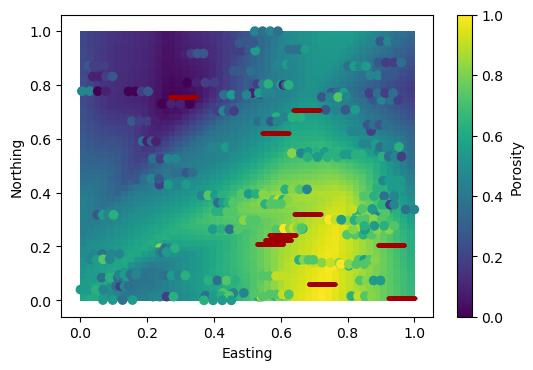

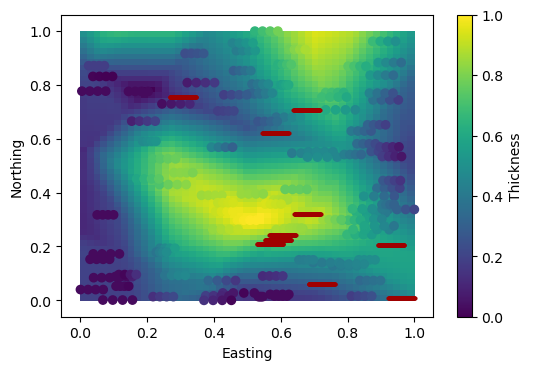

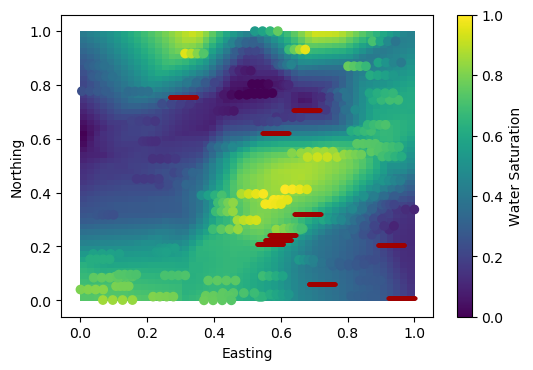

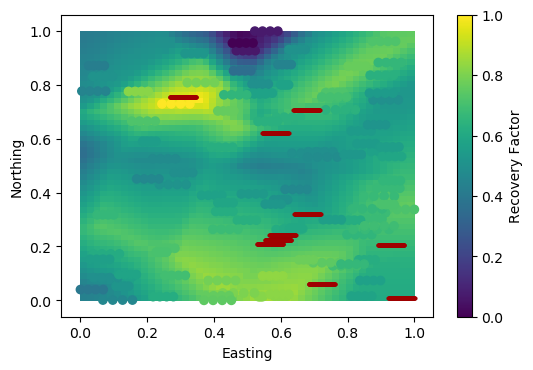

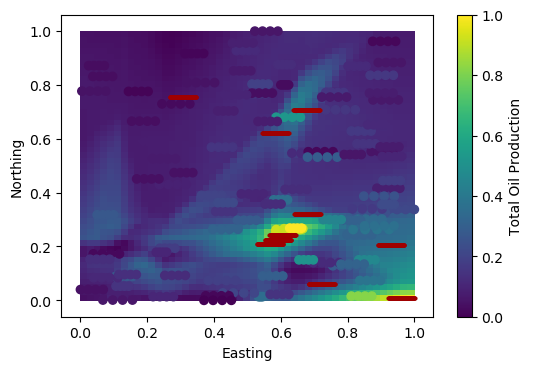

In [23]:
porosityNet.plotSimple()
thicknessNet.plotSimple()
wSaturationNet.plotSimple()
RFNet.plotSimple()
totalOilNet.plotSimple()

# <span style="color:blue">Use the Neural Networks to Populate Well Classes for the Wells we Create</span>

In [24]:
for addedWellClass in addedWellClasses:
    addedWellClass.thickness = thicknessNet.scalarY.inverse_transform(thicknessNet.model.predict(thicknessNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1)
    addedWellClass.porosity = porosityNet.scalarY.inverse_transform(porosityNet.model.predict(porosityNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1)
    addedWellClass.wSaturation = wSaturationNet.scalarY.inverse_transform(wSaturationNet.model.predict(wSaturationNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1)
    addedWellClass.RF = RFNet.scalarY.inverse_transform(RFNet.model.predict(RFNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1).mean()
    totalOil = totalOilNet.scalarY.inverse_transform(totalOilNet.model.predict(totalOilNet.scalarX.transform(np.array([addedWellClass.easting, addedWellClass.northing]).transpose()))).reshape(-1).mean()
    addedWellClass.oilByMonth = np.array(totalOil/12).repeat(12)

# <span style="color:blue">Total OOIP for our 10 wells</span>

In [25]:
np.array([addedWellClass.getOilInPlace() for addedWellClass in addedWellClasses]).sum()

65508321.007460594

# <span style="color:blue">Total RR for our 10 wells</span>

In [26]:
np.array([addedWellClass.getRecoverableReserves() for addedWellClass in addedWellClasses]).sum()

6377706.903312432

# <span style="color:blue">Total EUR for our 10 wells</span>

In [27]:
np.array([addedWellClass.getTotalProduction() for addedWellClass in addedWellClasses]).sum()

47030.82000732422

In [6]:
wells[0].LifeOfReservoir() * 12 * 30

14.01252195367659